In [187]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import emoji
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import davies_bouldin_score

# Load the CSV file (adjust the path as needed)
data_reviews = pd.read_csv(r"C:\Users\HARVIN RAJ\Desktop\stuff\Booking.com_Reviews.csv")

data_reviews['Positive Feedback'] = data_reviews['Positive Feedback'].str.replace(r'\bnothing\b', '', regex=True, case=False)
data_reviews['Negative Feedback'] = data_reviews['Negative Feedback'].str.replace(r'\bnothing\b', '', regex=True, case=False)

data_reviews['Review'] = data_reviews['Positive Feedback'].fillna('') + ' ' + data_reviews['Negative Feedback'].fillna('')
review_column = data_reviews['Review'].iloc[0:11576]

# Data Preprocessing and Cleaning Function
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in string.punctuation and word not in stopwords.words('english')]
    
    lemmatizer = WordNetLemmatizer()
    tagged_tokens = nltk.pos_tag(tokens)
    
    nouns = []
    for word, tag in tagged_tokens:
        if tag.startswith('NN'):  # Check if the POS tag is a noun
            noun_lemma = lemmatizer.lemmatize(word, nltk.corpus.wordnet.NOUN)
            nouns.append(noun_lemma)
    
    nouns = [emoji.demojize(word) if emoji.is_emoji(word) else word for word in nouns]
    
    return nouns

processed_reviews = review_column.apply(preprocess_text)

print(processed_reviews)

0        [tourist, spot, hotel, bar, night, star, staff...
1                                                 [choice]
2                 [location, perfect, theatre, land, food]
3                                    [everything, amazing]
4                 [staff, hotel, facility, tv, guide, see]
                               ...                        
11571        [location, air, threw, air, staff, ask, hung]
11572    [location, staff, food, room, room, window, wi...
11573    [hotel, service, room, cosy, choice, hotel, lo...
11574    [location, executive, lounge, staff, bell, boy...
11575    [location, bed, room, enough…, key, room, brea...
Name: Review, Length: 11576, dtype: object


In [188]:
data_reviews

,Hotel Name,Reviewer Name,Hometown,Traveller Type,Room Type,Nights Stayed,Stayed Month,Reviewed Date,Review Title,Positive Feedback,Negative Feedback,Review Score,Review
0,The Londoner,Chuvit,Thailand,Solo traveller,King Room,1 night,January 2024,3 January 2024,Front staff is very helpful and friendly. Even...,Even surrounding with tourist spot but inside ...,Breakfast need more varieties and 2 broken run...,10.0,Even surrounding with tourist spot but inside ...
1,The Londoner,Kay,United Kingdom,Couple,King Room,2 nights,May 2024,15 June 2024,Exceptional,Absolutely marvellous! Great choice too!,,10.0,Absolutely marvellous! Great choice too!
2,The Londoner,Eileen,United Kingdom,Couple,Deluxe King Room,3 nights,June 2024,14 June 2024,Very comfortable and very friendly staff.,Location is perfect for theatre land and food ...,,10.0,Location is perfect for theatre land and food ...
3,The Londoner,Andrai,United Kingdom,Couple,King Room,1 night,May 2024,11 June 2024,Beautiful and luxurious,Everything was amazing!,!,10.0,Everything was amazing! !
4,The Londoner,Carman,New Zealand,Solo traveller,Deluxe King Room,5 nights,June 2024,9 June 2024,I’ve found the place to stay on my London trips!!,Staff were great and the hotel facilities exce...,Tv guide was difficult to see what was on when...,10.0,Staff were great and the hotel facilities exce...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11571,The Dilly,Nicola,United Kingdom,Couple,Dilly Classic Double Room,1 night,March 2023,"March 13, 2023",disappointing,good location,the air conditioning was not working and threw...,6.0,good location the air conditioning was not wor...
11572,The Dilly,Hanne,Finland,Family,Dilly Classic Double Room,3 nights,March 2023,"March 13, 2023",A true five star experience with attention to ...,"The atmosphere, location, staff, food and the ...",Our room had covered windows since it faced th...,10.0,"The atmosphere, location, staff, food and the ..."
11573,The Dilly,Stephanie,United Kingdom,Group,Dilly Classic Double Room,1 night,March 2023,"March 13, 2023",The best of the best,the hotel went above and beyond to make us hav...,there is absolutely that we could have been u...,10.0,the hotel went above and beyond to make us hav...
11574,The Dilly,Tariq,Saudi Arabia,Family,Dilly Junior Suite,4 nights,March 2023,"March 13, 2023",Very expensive for its level of service,- Location\n- Executive lounge,- Rude staff (bell boy was rude and almost bro...,5.0,- Location\n- Executive lounge - Rude staff (b...


In [6]:
# Function to perform clustering on a chunk of word vectors
def cluster_chunk(word_vectors):
    similarity_matrix = cosine_similarity(word_vectors)
    
    ap = AffinityPropagation(affinity='precomputed', preference=np.median(similarity_matrix), damping=0.9, max_iter=2000, convergence_iter=50).fit(similarity_matrix)
    return ap

In [7]:
def process_chunk(chunk, word2vec_model):
    words = []
    word_vectors = []
    for sentence in chunk:
        for word in sentence:
            if word in word2vec_model.wv:
                words.append(word)
                word_vectors.append(word2vec_model.wv[word])

    word_vectors = np.array(word_vectors)

    ap = cluster_chunk(word_vectors)  
    return ap, words, word_vectors

In [8]:
# Divide the word vectors into smaller chunks
chunk_size = 300  
chunks = [processed_reviews[i:i + chunk_size] for i in range(0, len(processed_reviews), chunk_size)]

In [3]:
print(len(chunks))

39

In [10]:
# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=processed_reviews, vector_size=50, window=4, min_count=5)

In [36]:
all_cluster_results = [None] * 40

In [37]:
cluster_resultant=[None] * 41

In [38]:
print(len(cluster_resultant))

41


In [39]:
cluster_results = process_chunk(chunks[0], word2vec_model)
all_cluster_results[0]=cluster_results

In [40]:
print(all_cluster_results[0])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95207626), ['tourist', 'spot', 'hotel', 'bar', 'night', 'star', 'staff', 'management', 'jacuzzi', 'breakfast', 'need', 'variety', 'track', 'time', 'choice', 'location', 'perfect', 'theatre', 'land', 'food', 'everything', 'amazing', 'staff', 'hotel', 'facility', 'tv', 'see', 'location', 'staff', 'wow', 'factor', 'lounge', 'wait', 'time', 'hotel', 'music', 'lobby', 'breakfast', 'pool', 'room', 'hang', 'towel', 'space', 'suitcase', 'clothes', 'location', 'hotel', 'everything', 'room', 'staff', 'toilet', 'person', 'location', 'excellent', 'restaurant', 'price', 'drink', 'bar', '’', 'everything', 'location', 'facility', 'staff', 'doorman', 'desk', 'staff', 'team', 'everything', 'room', 'toilet', 'seat', 'pool', 'gym', 'addition', 'location', 'worth', 'penny', 'location', 'size', 'everything', 'hotel', 'location', 'room', 'view', 'breakfast', 'pool', 'rooftop', 'loca

In [41]:
cluster_results = process_chunk(chunks[1], word2vec_model)
all_cluster_results[1]=cluster_results

In [43]:
print(all_cluster_results[1])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95116746), ['staff', 'room', 'everything', 'need', 'option', 'room', 'service', 'menu', 'staff', 'lot', 'stuff', 'property', 'area', 'square', 'everything', 'start', 'scent', 'member', 'staff', 'assistance', 'mile', 'need', 'facility', 'staff', 'clean', 'trouble', 'leak', 'roof', 'someone', 'desk', 'location', 'leicester', 'square', 'convenient', 'walk', 'place', 'decor', 'staff', 'query', 'change', 'room', 'bit', 'buffet', 'staff', 'everything', 'room', 'facility', 'location', 'way', 'part', 'london', 'hotel', 'staff', 'design', 'hotel', 'class', 'luxury', 'facility', 'staff', 'member', 'customer', 'service', 'skill', 'hotel', 'breakfast', 'location', 'room', 'sort', 'bathroom', 'bit', 'location', 'room', 'service', 'room', 'facility', 'staff', 'location', 'location', 'staff', 'room', 'pool', '’', 'need', 'breakfast', 'tea/coffee', 'lounge', 'ideal', 'toilet',

In [44]:
cluster_results = process_chunk(chunks[2], word2vec_model)
all_cluster_results[2]=cluster_results

print(all_cluster_results[2])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9523092), ['hotel', 'staff', 'room', 'location', 'feel', 'phone', 'hotel', 'course', 'hotel', 'help', 'report', 'value', 'money', 'london', 'detail', 'pool', 'weekend', 'bar', 'rooftop', 'noisy', 'weekend', 'ask', 'room', 'floor', 'everything', 'perfect', 'staff', 'everything', 'everything', 'excellent', 'location', 'area', 'room', 'bit', 'storage', 'hotel', 'area', 'reach', 'place', 'staff', 'time', 'room', 'clean', 'surroundings', 'walk', 'hotel', 'hotel', 'booking', 'everything', 'decor', 'staff', 'breakfast', 'waiter', 'waitress', 'meal', 'everyone', '’', 'anything', 'coffee', 'minute', 'staff', 'service', 'nobody', 'breakfast', 'run', '’', 'menu', '’', 'minute', 'people', 'drink', 'staff', 'birthday', 'treat', 'leicester', 'square', 'bit', 'night', 'hotel', 'london', 'location', 'staff', 'room', 'lot', 'facility', '’', 'gap', 'toilet', 'option', 'everythin

In [45]:
cluster_results = process_chunk(chunks[3], word2vec_model)
all_cluster_results[3]=cluster_results

print(all_cluster_results[3])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9493379), ['location', 'staff', 'cost', 'room', 'size', 'service', 'facility', 'room', 'detail', 'door', 'stage', 'bar', 'drink', 'everything', 'service', 'service', 'bottle', 'room', '’', 'deal', 'stay', 'location', 'staff', 'member', 'luggage', 'hotel', 'room', 'credit', 'hotel', 'attention', 'detail', 'hotel', 'facility', 'room', 'spotless', 'pillow', 'toilet', 'seat', 'game', 'work', '’', 'residence', 'area', 'bar', 'job', 'credit', 'hotel', 'drink', 'roof', 'bar', 'pub', 'sunday', 'monday', 'reservation', 'staff', 'hotel', 'facility', 'quality', 'breakfast', 'room', 'price', 'breakfast', 'room', 'staff', 'location', 'everything', 'hotel', 'staff', 'hotel', 'exceptional', 'everything', 'everything', 'location', 'interior', 'bar', 'room', 'gym', 'equipment', 'space', 'toilet', 'addition', 'hair', 'conditioner', 'shampoo', 'hotel', 'breakfast', 'square', 'roo

In [46]:
cluster_results = process_chunk(chunks[4], word2vec_model)
all_cluster_results[4]=cluster_results

print(all_cluster_results[4])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9453889), ['rooftop', 'area', 'view', 'vibe', 'room', 'hotel', 'panel', 'bathroom', 'light', 'staff', 'hotel', 'hotel', 'minute', 'hotel', 'doorman', 'time', 'hotel', 'reception', 'staff', 'staff', 'hotel', 'clean', 'facility', 'thing', 'hotel', 'staff', 'pool', 'lift', 'rooftop', 'nice', 'pool', 'area', 'service', 'bar', 'cafe', 'room', 'size', 'staff', 'location', 'bar', 'temperature', 'room', '’', 'stuffy', 'window', 'staff', 'reception', 'breakfast', 'value', 'staff', 'rest', 'hotel', 'selection', 'time', 'room', 'location', 'price', 'quality', 'breakfast', 'view', 'window', 'location', 'room', 'morning', 'warm', 'air', 'sleep', 'building', 'bed', 'head', 'breakfast', 'hostess', 'evening', 'bartender', 'checkin', 'impression', 'room', 'hair', 'bath', 'mini', 'bar', 'item', 'thing', 'coffee', 'supply', '..', 'picture', 'anything', 'staff', 'location', 'time'

In [47]:
cluster_results = process_chunk(chunks[5], word2vec_model)
all_cluster_results[5]=cluster_results

print(all_cluster_results[5])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9463038), ['location', 'facility', 'staff', 'time', 'room', 'morning', 'check', 'staff', 'rooftop', 'bar', 'min', 'use', 'room', 'drainage', 'problem', 'bed', 'air', 'con', 'room', 'work', 'mould', 'shower', 'window', 'location', 'staff', 'efficient', 'everything', 'doorman', '’', 'get', 'room', '’', 'complain', '’', 'day', 'room', 'size', 'staff', 'office', 'area', 'term', 'night', 'activity', 'hotel', 'staff', 'hour', 'reason', 'hotel', 'staff', 'room', 'feeling', 'location', 'staff', 'bed', 'terrace', 'spa', 'facility', 'hotel', 'location', 'book', 'spa', 'minute', 'slot', 'location', 'air', 'broken', 'manager', 'room', 'hour', 'room', 'cost', 'beer', 'extortionate', 'gown', 'room', 'spa', 'request', 'spa', 'manager', 'help', 'everything', 'clean', 'staff', 'room', 'street', 'view', 'bar', 'breakfast', 'choice', 'food', 'breakfast', 'room', 'hour', 'check', 

In [48]:
cluster_results = process_chunk(chunks[6], word2vec_model)
all_cluster_results[6]=cluster_results

print(all_cluster_results[6])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.94802266), ['well', 'room', 'bed', 'selection', 'location', 'pool', 'kid', 'use', 'facility', 'room', 'service', 'order', 'eat', 'restaurant', 'location', 'hotel', 'business', 'travel', 'city', 'london', 'minute', 'station', 'restaurant', 'room', 'london', 'standard', 'time', 'room', 'court', 'window', 'bed', 'room', 'dark', 'phone', 'reception', 'window', 'window', 'air', 'noise', 'court', 'ventilation', 'system', 'day', 'noise', 'night', 'panel', 'bathroom', 'door', 'night', 'room', 'tv', 'toilet', 'brush', 'hotel', 'correct', 'business', 'address', 'checkin', 'business', 'card', 'purpose', 'minute', 'meeting', 'lot', 'choice', 'day', 'ham', 'spoon', 'coffee', 'tea', 'day', 'issue', 'container', 'milk', 'room', 'spa', 'access', 'bonus', 'staff', 'luggage', 'room', 'prosecco', 'connection', '’', 'access', 'location', 'facility', 'downstairs', 'staff', 'breakfa

In [49]:
cluster_results = process_chunk(chunks[7], word2vec_model)
all_cluster_results[7]=cluster_results

print(all_cluster_results[7])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9440663), ['location', 'hotel', '..', 'location', 'good', 'robe', 'call', 'call', 'bedroom', 'lobby', 'entrance', 'thought', 'spa', 'staff', 'hotel', 'bar', 'staff', 'room', 'bed', 'bathroom', 'thing', 'mirror', 'room', 'bathroom', '’', 'issue', 'comfy', 'room', 'location', 'way', 'review', 'staff', 'booking', 'spa', 'leisure', 'facility', 'class', 'breakfast', 'service', 'staff', 'breakfast', 'price', 'drink', 'hotel', 'bar', 'upstairs', 'spend', 'person', 'someone', 'view', 'beer', 'lot', 'customer', 'money', 'sense', 'roof', 'bar', 'bath', 'room', 'pool', 'advance', 'location', 'staff', 'property', 'staff', 'coffee', 'machine', 'room', 'pod', 'plug', 'room', 'work', 'customer', 'service', 'way', 'spa', 'hotel', 'spa', 'partner', 'staff', 'need', 'room', 'upgrade', 'wine', 'sweet', 'treat', 'balloon', 'decoration', 'plenty', 'restaurant', 'food', 'problem', '

In [50]:
cluster_results = process_chunk(chunks[8], word2vec_model)
all_cluster_results[8]=cluster_results

print(all_cluster_results[8])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9482271), ['restaurant', 'family', '’', 'bar', 'breakfast', 'bottle', 'card', '’', 'hotel', 'room', 'ie', 'spa', 'tv', 'etc', 'room', 'area', 'reception', 'check', 'time', 'process', 'hand', 'wifi', 'keycard', 'info', 'desk', 'bedroom', 'everything', 'hotel', 'breakfast', 'check', 'lobby', 'couple', 'issue', 'hotel', 'staff', 'stair', 'bedding', 'place', 'start', 'time', 'room', 'bed', 'comfy', 'breakfast', 'people', 'question', 'queue', 'room', 'towel', 'breakfast', 'breakfast', 'service', 'bar', 'party', 'bar', 'drink', 'room', 'bill', 'policy', 'payment', 'invoice', 'payment', 'star', 'policy', 'breakfast', 'husband', '’', 'omelette', 'room', 'egg', 'breakfast', 'room', 'staff', 'helpful', 'room', 'staff', 'member', 'rude', 'breakfast', 'room', 'min', 'food', 'staff', 'accommodate', 'area', 'dark', 'touch', 'delight', 'thing', 'executive', 'lounge', 'night',

In [51]:
cluster_results = process_chunk(chunks[9], word2vec_model)
all_cluster_results[9]=cluster_results

print(all_cluster_results[9])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95020103), ['breakfast', 'room', 'instruction', 'staff', 'clean', 'lot', 'touch', 'lounge', 'breakfast', 'property', 'location', 'clean', 'bill', 'staff', 'stay', 'service', 'charge', 'guest', 'pay', '’', 'person', 'bill', '’', 'time', 'speak', 'manager', 'catch', 'guy', 'reception', 'suit', 'manager', 'call', '’', 'montcalm', 'day', 'weekend', '’', 'stop', 'make', 'people', 'situation', 'property', 'room', 'size', 'staff', 'spa', 'facility', 'room', 'room', 'tv', 'hotel', 'restaurant', 'staff', 'room', 'service', 'min', 'min', 'breakfast', 'bed', 'atrium', 'bar', 'restaurant', 'staff', 'member', 'eye', 'contact', 'club', 'room', 'partner', 'name', 'lady', 'entry', 'room', 'control', 'panel', 'room', 'heat', 'light', 'maintenance', 'engineer', 'panel', 'room', 'panel', 'time', 'night', 'light', 'use', 'room', 'metal', 'frame', 'cushion', 'cover', 'sit', 'bookin

In [52]:
cluster_results = process_chunk(chunks[10], word2vec_model)
all_cluster_results[10]=cluster_results

print(all_cluster_results[10])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9497911), ['location', 'minute', 'walk', 'tube', 'staff', 'trouble', 'glass', 'arrival', 'dislike', 'menu', 'restaurant', 'downstairs', 'hotel', 'staff', 'room', 'anniversary', 'room', 'reception', 'room', 'dinner', 'snack', 'drink', 'pool', 'morning', 'restaurant', 'room', 'service', '’', 'nice', 'facility', 'location', 'closing', 'location', 'staff', 'session', 'slot', 'tea', '’', 'fault', 'anything', 'environment', 'swimming', 'bar', 'bed', 'room', 'staff', 'location', 'friendliness', 'doorman', 'carpet', 'look', 'location', 'room', 'bit', 'london', 'house', 'time', 'time', 'staff', 'room', 'request', 'hotel', 'room', 'bar', 'restaurant', 'room', 'spotless', 'water', 'day', 'air', 'lounge', 'look', 'london', 'location', 'place', 'visit', 'sight', 'restaurant', 'moorgate', 'tube', 'station', 'minute', 'anything', 'hotel', 'staff', 'helpful', 'pleasant', 'anyt

In [27]:
cluster_results = process_chunk(chunks[11], word2vec_model)
all_cluster_results[11]=cluster_results

print(all_cluster_results[11])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9599517), ['glass', 'prosecco', 'arrival', 'hotel', 'staff', 'beautiful', 'room', 'area', 'room', 'location', 'room', 'cleanliness', 'facility', 'everything', 'hotel', 'staff', 'view', 'square', '’', 'service', 'view', 'room', '’', 'roof', 'room', 'dust', 'room', 'service', 'hour', 'reception', 'access', 'roof', 'top', 'availability', 'table', 'staff', 'location', 'room', 'stay', 'room', 'panel', 'wall', 'aircon', 'change', 'room', 'temperature', 'temp', 'tv', 'hotel', 'room', 'room', 'panel', 'tv', 'room', 'hotel', 'room', 'reception', 'request', 'cancel', 'refund', 'order', 'taxi', 'pan', 'time', 'view', 'charge', 'breakfast', 'everything', 'room', 'room', 'dirty', 'window', 'night', 'roof', 'terrace', 'bill', 'reception', 'empty', 'room', 'snack', 'view', 'room', 'view', 'room', 'light', 'star', 'hotel', 'others', 'hotel', 'time', 'checkout', 'staff', 'kind'

In [28]:
cluster_results = process_chunk(chunks[12], word2vec_model)
all_cluster_results[12]=cluster_results

print(all_cluster_results[12])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9523057), ['location', 'staff', 'facility', 'staff', 'communication', 'booking', 'system', 'bar', 'restaurant', 'birthday', 'person', 'someone', 'mistake', 'london', 'everything', 'guy', 'daniel', '’', 'anything', 'staff', 'birthday', 'room', 'event', 'day', 'room', 'bed', 'staff', 'surprise', 'double', 'request', 'everything', 'na', 'hotel', 'everything', 'hotel', 'room', 'staff', 'partner', 'manager', 'room', 'left', 'petal', 'offering', 'service', 'doubt', 'star', 'experience', 'staff', 'royalty', 'stay', 'perfect', 'location', 'attention', 'detail', 'look', 'guest', 'location', 'convenient', 'work', 'bar', 'roof', 'area', 'check', 'process', 'date', 'technology', 'school', 'credit', 'card', 'part', 'process', 'time', 'reason', 'security', 'reason', 'online', 'advance', 'booking', 'room', 'temperature', 'night', 'bed', 'night', 'air', 'con', 'hotel', 'dinner

In [29]:
cluster_results = process_chunk(chunks[13], word2vec_model)
all_cluster_results[13]=cluster_results

print(all_cluster_results[13])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9539622), ['lift', 'dingy', 'need', 'towel', 'gown', 'room', 'staff', 'service', 'arrival', 'pool', 'facility', 'minute', 'slot', 'hotel', 'pool', 'day', 'time', 'slot', 'feel', 'race', 'use', 'facility', 'time', 'heating', 'amazing', 'bed', 'room', '’', 'feel', 'staff', 'breakfast', 'money', 'man', 'reception', 'everyone', 'room', 'mini', 'bar', 'bath', 'robe', 'club', 'toiletry', 'case', 'hand', 'print', 'door', 'hand', 'print', 'dirty', 'reception', 'covid', 'mini', 'bar', 'tea', 'coffee', 'people', 'room', 'door', 'men', 'stair', 'bar', 'office', 'staff', 'area', 'people', 'bar', 'restaurant', 'book', 'stair', 'restaurant', 'advance', 'bar', 'hand', 'print', 'hotel', 'covid', 'location', 'roof', 'bar', 'room', 'shower', 'slipper', 'tv', 'iron', 'staff', 'water', 'mini', 'bar', 'bacon', 'breakfast', 'everything', 'staff', 'room', 'someone', '’', 'hair', '’',

In [30]:
cluster_results = process_chunk(chunks[14], word2vec_model)
all_cluster_results[14]=cluster_results

print(all_cluster_results[14])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.94881517), ['room', 'bed', 'location', 'experience', 'bathroom', 'shower', 'lift', 'food', 'staff', 'everything', 'perfect', 'breakfast', 'gym', 'staff', 'lady', 'water', 'room', 'convenient', 'n/a', 'room', 'lounge', 'floor', 'staff', 'food', 'bit', 'location', 'morning', 'flight', 'comfortable', 'night', 'hotel', 'location', 'room', 'adult', 'child', 'bed', 'share', 'sheet', 'hotel', 'bedding', 'family', 'flight', 'clean', 'comfortable', 'family', 'room', 'room', 'bathroom', 'plane', 'window', 'morning', 'walk', 'walkway', 'room', 'day', 'hotel', 'form', 'instruction', 'location', 'comfort', 'cleanliness', 'convenience', 'view', 'airport', 'breakfast', 'book', 'everything', 'perfect', 'fab', 'access', 'flight', 'drink', 'food', 'vanda', 'restaurant', 'everything', 'list', 'bar', 'location', 'quality', 'location', 'airport', 'pay', 'gatwick', 'airport', '£6', 

In [31]:
cluster_results = process_chunk(chunks[15], word2vec_model)
all_cluster_results[15]=cluster_results

print(all_cluster_results[15])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9459261), ['location', 'airport', 'nibble', 'lounge', 'variety', 'comfy', 'staff', 'food', 'standard', 'meal', 'meal', 'lot', 'money', 'chip', 'airport', 'access', 'ok', 'location', 'staff', 'breakfast', 'view', 'aircraft', 'n/a', 'access', 'parking', 'convenient', 'food', 'drink', 'convenient', 'position', 'property', 'airport', 'travel', 'morning', 'hour', 'flight', 'fact', 'flannel', 'hotel', 'provide', 'location', 'shower', 'staff', 'room', 'journey', 'breakfast', 'morning', 'good', 'bed', 'room', 'breakfast', 'lot', 'choice', 'leg', 'holiday', 'safety', 'issue', 'rail', 'hold', 'bath', 'surface', 'slippery', 'people', 'member', 'staff', 'lift', 'note', 'safety', 'comment', 'lift', 'spray', 'spray', 'location', 'terminal', 'everything', 'everything', 'staff', 'person', 'way', 'stay', 'experience', 'case', 'stay', 'foyer', 'restaurant', 'room', 'pure', 'comf

In [32]:
cluster_results = process_chunk(chunks[16], word2vec_model)
all_cluster_results[16]=cluster_results

print(all_cluster_results[16])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.94974345), ['location', 'room', 'work', 'room', 'breakfast', 'selection', 'fruit', 'tidy', 'restaurant', 'airport', 'terminal', 'lobby', 'staff', 'helpful', 'quality', 'bathroom', 'quality', 'towel', 'restaurant', 'pricey', 'meeting', 'expectation', 'restaurant', 'exceptional', 'bread', 'restaurant', 'bread', 'staff', 'son', 'walk', 'walk', 'way', 'airport', 'minute', 'food', 'parking', 'flight', 'meant', 'hotel', 'hotel', 'mark', 'lobby', 'situation', 'lobby', 'room', 'location', 'staff', 'room', 'standard', 'double', 'reception', '’', 'night', 'scene', 'food', 'brasserie', 'location', 'flight', 'walk', 'corridor', 'room', 'shuttle', 'terminal', 'location', 'staff', 'friendliness', 'quality', 'staff', 'bill', 'booking.com', 'minute', 'greet', 'process', 'location', 'room', 'restaurant', 'room', '’', 'lamp', 'everything', 'bedroom', 'hotel', 'sound', 'proof', '

In [33]:
cluster_results = process_chunk(chunks[17], word2vec_model)
all_cluster_results[17]=cluster_results

print(all_cluster_results[17])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.94995517), ['location', 'room', 'dark', 'guest', 'corridor', 'car', 'alarm', 'flight', 'departure', 'item', 'find', 'hotel', 'housekeeping', 'address', '’', 'reply', 'location', 'na', 'location', 'property', 'issue', 'proximity', 'terminal', 'bar', 'facility', 'terminal', 'fine', 'building', 'breakfast', 'menu', 'start', 'day', 'bathroom', 'location', 'airport', 'access', 'restaurant', 'night', 'family', 'room', 'daughter', 'podium', 'restaurant', 'bar', 'lounge', 'ambience', 'ate', 'smile', 'joke', 'food', 'bedroom', 'air', 'difference', 'night', 'sleep', 'access', 'tunnel', 'perfect', 'location', 'airport', 'staff', 'room', 'bit', 'staff', 'check', 'computer', 'issue', 'staff', 'way', 'journey', 'get', 'convenient', 'gatwick', 'bed', 'restaurant', 'class', 'bar', 'return', 'stay', 'location', 'excellent', 'distance', 'departure', 'hall', 'service', 'restauran

In [34]:
cluster_results = process_chunk(chunks[18], word2vec_model)
all_cluster_results[18]=cluster_results

print(all_cluster_results[18])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9494127), ['location', 'terminal', '’', 'bed', '’', '’', 'get', 'girl', 'people', 'person', 'hotel', 'bit', 'value', 'hilton', 'staff', 'receptionist', 'lounge', 'food', 'waitress', 'excellent', 'room', 'staff', 'couple', 'tea', 'bag', 'room', 'everything', 'brasserie', 'eat', 'bit', 'issue', 'sofitel', 'everyone', 'feel', 'restaurant', 'day', 'hotel', 'convenient', 'airport', 'parking', 'location', 'room', 'clean', 'desk', 'helpful', 'reservation', 'service', 'restaurant', 'restaurant', 'menu', 'dessert', 'waiter', 'order', 'share', 'pasta', 'order', 'dessert', 'waiter', 'order', 'dessert', 'order', 'list', 'bottle', 'water', 'order', 'wine', 'couple', 'time', 'waiter', 'side', 'plate', 'share', 'glass', 'champagne', 'waiter', 'cutlery', 'food', 'order', 'dessert', 'let', 'kitchen', 'order', 'dessert', 'waiter', 'need', 'server', 'restaurant', 'service', 'look

In [35]:
cluster_results = process_chunk(chunks[19], word2vec_model)
all_cluster_results[19]=cluster_results

print(all_cluster_results[19])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95043826), ['quality', '’', 'understand', 'location', 'flight', 'access', 'train', 'selection', 'restaurant', 'reception', 'check', 'air', 'con', 'room', 'bar', 'view', 'reception', 'pleasant', 'ok', 'hotel', 'room', 'terrific', 'location', 'parking', 'experience', 'hour', 'meal', 'starter', 'simple', 'everyone', 'restaurant', 'communication', 'staff', 'look', 'whilst', 'staff', 'kind', 'moment', 'wife', 'moment', 'place', 'night', 'property', 'appearance', 'room', 'mirror', 'bathroom', 'lobby', 'view', 'room', 'everything', 'place', 'elevator', 'location', 'plug', 'distance', 'airport', 'restaurant', 'terminal', 'experience', 'sofitel', 'lgw', 'terminal', 'issue', 'room', 'service', 'sound', 'management', 'airport', 'hotel', 'flight', 'london', 'airport', 'staff', 'room', 'air', 'conditioning', 'bar', 'location', 'property', 'jet', 'bag', 'drop', 'option', 'ch

In [36]:
cluster_results = process_chunk(chunks[20], word2vec_model)
all_cluster_results[20]=cluster_results

print(all_cluster_results[20])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95023954), ['bed', 'reach', 'kind', 'staff', 'gym', 'attention', '..', 'luxury', 'airport', '’', 'staying', 'choice', 'restaurant', 'grab', 'breakfast', 'bed', 'selection', 'restaurant', 'location', 'convenient', 'location', 'airport', 'staff', 'reception', 'slow', 'service', 'lady', 'counter', 'family', 'toddler', 'checkin', 'drop', 'hour', 'clean', 'room', 'tea', 'coffee', '..', 'hotel', 'checkin', 'flight', 'nil', 'room', 'need', 'airport', 'terminal', 'time', 'dinner', 'reservation', 'everything', 'lift', 'action', 'room', 'time', 'point', 'use', 'night', 'proximity', 'beautiful', 'bed', '’', 'stay', 'shuttle', 'train', 'bar', 'dining', 'facility', 'breakfast', 'timing', 'checkout', 'time', 'slipper', 'room', 'morning', 'someone', 'room', 'sign', 'job', 'chain', 'place', 'room', 'dining', 'menu', 'airport', 'hotel', 'resident', '£25', 'mean', 'hotel', 'staf

In [37]:
cluster_results = process_chunk(chunks[21], word2vec_model)
all_cluster_results[21]=cluster_results

print(all_cluster_results[21])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95023954), ['window', 'toiletry', 'hairdryer', 'room', 'finish', 'crack', 'ceiling', 'paint', 'sink', 'head', 'facility', 'location', 'staff', 'front', 'desk', 'room', 'hotel', 'bed', 'tv', 'bonus', 'staff', 'facility', 'hotel', 'card', 'lift', 'explanation', 'lift', 'card', 'floor', 'luggage', 'porter', 'lift', 'lift', 'staff', 'room', 'desk', 'use', 'work', 'use', 'desk', 'parent', 'wheelchair', 'hotel', 'front', 'staff', 'man', 'room', 'soundproof', 'room', 'plane', 'noise', 'room', 'size', 'coffee', 'tea', 'bed', 'pillow', 'shower', 'product', 'location', 'restaurant', 'price', 'expensive', 'location', 'excellent', 'airport', 'room', 'bed', 'quality', 'travel', 'stay', 'information', 'reception', 'resturant', 'breakfast', 'incorrect', 'book', 'breakfast', 'room', 'list', 'booking', 'confirm', 'detail', 'breakfast', 'arrangement', 'room', 'situation', 'check

In [38]:
cluster_results = process_chunk(chunks[22], word2vec_model)
all_cluster_results[22]=cluster_results

print(all_cluster_results[22])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9519456), ['proximity', 'airport', 'staff', 'efficient', 'hotel', 'feel', 'start', 'holiday', 'doorman', 'car', 'duration', 'holiday', 'room', 'light', 'airy', 'shower', 'suitcase', 'offer', 'chocolate', 'coffee', 'facility', 'breakfast', 'dinner', 'disaster', 'son', '’', 'meal', 'hotel', 'time', 'location', 'departure', 'fix', 'atmosphere', 'location', 'super', 'comfy', 'bed', 'room', 'service', 'breakfast', 'time', 'check', 'luggage', 'time', 'location', 'stay', 'stay', 'breakfast', 'na', 'location', 'gatwick', 'airport', 'staff', 'manager', 'change', 'furniture', 'room', 'proximity', 'airport', 'option', 'amount', 'time', 'location', 'airport', 'room', 'bed', 'cosy', 'class', 'security', 'woman', 'traveller', 'feel', 'secure', 'surprise', 'super', 'quality', 'sofitel', 'top', 'everything', 'room', '’', 'get', 'night', 'sleep', 'food', 'staff', 'helpful', 'st

In [39]:
cluster_results = process_chunk(chunks[23], word2vec_model)
all_cluster_results[23]=cluster_results

print(all_cluster_results[23])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9461857), ['location', 'excellent', 'facility', 'food', 'staff', 'night', 'airport', 'room', 'people', 'suitcase', 'staff', 'facility', 'flight', 'hotel', 'staff', 'room', 'top', 'notch', 'hotel', 'room', 'reason', 'sofa', 'bed', 'room', 'room', '’', 'milk', 'fridge', 'reception', 'morning', 'someone', 'bring', 'milk', 'room', 'minute', 'member', 'staff', 'cleaning', 'room', 'hotel', 'fire', 'alarm', 'room', 'alarm', 'room', 'breakfast', 'someone', 'fire', 'alarm', 'night', 'hour', 'bed', 'night', 'sleep', 'year', 'hotel', 'morning', 'flight', '’', 'anything', 'property', 'luxury', 'comfort', 'location', 'plug', 'bathroom', 'spot', 'hair', 'mirror', 'thing', 'matter', 'woman', 'location', 'quality', 'comfort', 'thanks', 'location', 'room', 'meal', '’', 'get', 'night', '’', 'sleep', 'flight', 'noise', 'shuttle', 'train', 'room', 'modern', 'location', 'location',

In [40]:
cluster_results = process_chunk(chunks[24], word2vec_model)
all_cluster_results[24]=cluster_results

print(all_cluster_results[24])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95023954), ['flight', 'home', 'morning', 'receptionist', 'drink', 'bar', 'meal', 'restaurant', 'gesture', 'guest', 'tray', 'crisp', 'drink', 'purchase', 'drink', 'convenient', 'airport', 'hotel', 'staff', 'bar', 'snack', 'order', '’', 'bit', 'convenient', 'room', 'location', 'airport', 'room', 'temperature', 'clean', 'shower', 'brilliant', 'quality', 'staff', 'restaurant', 'food', 'cold', 'waitress', 'blanket', 'thing', 'head', 'tidy', 'milk', 'tea', 'morning', 'morning', 'see', 'sink', 'need', 'hotel', 'facility', 'room', 'sleep', 'location', 'room', 'staff', 'room', 'hotel', 'hotel', 'staff', 'member', 'check', 'time', 'time', 'location', 'heart', 'gatwick', 'airport', 'bit', 'pricey', 'location', 'future', 'staff', 'location', 'breakfast', 'hotel', 'airport', 'hotel', 'price', 'standard', 'room', 'bathroom', 'comfort', 'hotel', 'expectation', 'airport', 'hot

In [41]:
cluster_results = process_chunk(chunks[25], word2vec_model)
all_cluster_results[25]=cluster_results

print(all_cluster_results[25])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.943411), ['location', 'travel', 'tv', 'room', '’', 'room', 'chair', 'wife', 'hair', 'makeup', 'na', 'location', 'bed', 'pillow', 'room', 'location', 'airport', 'terminal', 'bathroom', 'location', 'maintenance', 'work', 'floor', 'noisy', 'excellent', 'comparison', 'star', 'hotel', 'room', 'shower', 'location', 'end', 'shuttle', 'location', 'cost', 'hour', 'flight', 'convenient', 'noise', 'bed', 'shower', 'food', 'lift', 'broken', 'room', 'beautiful', 'view', 'plane', 'morning', 'get', 'airport', 'area', 'bar', 'sit', 'foyer', 'enjoy', 'glass', 'wine', 'location', 'feel', 'room', 'service', 'speedy', 'staff', '’', 'excellent', 'drop', 'flight', 'room', 'clean', 'restaurant', 'choice', 'dish', 'suit', 'room', 'waitress', 'restaurant', 'rude', 'discount', 'room', 'location', 'expensive', 'location', 'service', 'parking', 'location', 'restaurant', 'runway', 'view', 

In [42]:
cluster_results = process_chunk(chunks[26], word2vec_model)
all_cluster_results[26]=cluster_results

print(all_cluster_results[26])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9462575), ['proximity', 'terminal', 'train', 'station', 'location', 'location', 'location', 'cleanliness', 'location', 'room', 'bed', 'room', 'bed', 'staff', '’', 'brasserie', 'restaurant', '’', 'eat', 'smelt', 'pub', 'service', 'airport', 'clean', 'staff', 'convenient', 'location', 'fine', 'location', '’', 'air', 'room', 'morning', 'flight', 'bed', 'price', 'simple', 'food', 'drink', 'comfort', 'breakfast', 'location', 'bathroom', 'door', 'airport', 'check', 'time', 'problem', 'system', 'room', 'view', 'location', 'location', 'excellent', 'bed', 'bathroom', 'staff', 'check-in', 'hotel', 'staff', 'location', 'room', 'facility', 'room', 'service', 'gym', 'job', 'location', 'day', 'flight', 'min', 'staff', 'condiment', 'room', 'problem', 'attitude', 'pool', 'degree', 'couple', 'degree', 'cooler', 'degree', 'proximity', 'runway', 'view', 'airport', 'location', 're

In [43]:
cluster_results = process_chunk(chunks[27], word2vec_model)
all_cluster_results[27]=cluster_results

print(all_cluster_results[27])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.94549155), ['hotel', 'facility', 'staff', 'staff', 'restaurant', 'standard', 'lift', 'foyer', 'everything', 'fine', 'family', 'room', 'parking', 'family', 'room', 'room', 'location', 'north', 'restaurant', 'reservation', 'hour', 'half', 'reservation', 'dinner', 'airport', '’', 'walking', 'distance', 'room', 'bed', 'shower', 'control', 'location', 'room', 'hotel', 'airport', 'room', 'food', 'lobby', 'downstairs', 'front', 'desk', 'professional', 'word', '’', 'round', 'tunnel', 'line', 'residence', 'tunnel', 'entrance', 'travel', 'partner', '’', 'bag', 'hair', 'hour', '’', 'see', 'feather', 'line', 'hotel', 'kind', '’', 'property', '’', 'hotel', 'location', 'cleanliness', 'bed', 'pricy', 'food', 'selection', 'service', 'attentive', 'hotel', 'airport', 'hear', 'plane', 'noise', 'room', 'wow', 'bar', 'price', 'glass', 'wine', 'bottle', 'location', 'room', 'view', '

In [44]:
cluster_results = process_chunk(chunks[28], word2vec_model)
all_cluster_results[28]=cluster_results

print(all_cluster_results[28])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95023954), ['location', 'price', 'difficulty', 'reach', 'netflix', 'location', 'fire', 'alarm', 'bed', 'breakfast', 'room', 'power', 'wait', 'hour', 'trip', 'reception', 'husband', 'phone', 'call', '’', 'dark', '’', 'noise', 'control', 'panel', 'hour', 'sleep', 'staff', 'decor', 'area', 'view', 'airport', 'cool', 'staff', 'effort', 'help', 'reason', 'hotel', 'mattress', 'room', 'service', 'charge', 'food', 'bar', 'restaurant', 'price', 'room', 'noisy', 'night', 'plane', '’', 'hotel', 'sound', 'room', 'service', 'room', 'hotel', 'price', 'check', 'room', 'rate', 'bar', '’', 'bar', 'right', 'hand', '’', 'know', 'hand', 'location', 'time', 'room', 'machine', 'room', 'interior', 'bar', 'staff', 'information', 'hotel', 'stay', 'parking', 'size', 'shower', 'pillow', 'air', 'temperature', 'change', 'pad', 'loud', 'cold', 'change', 'pillow', 'aircon', 'sleep', 'locatio

In [45]:
cluster_results = process_chunk(chunks[29], word2vec_model)
all_cluster_results[29]=cluster_results

print(all_cluster_results[29])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.950692), ['room', 'size', 'room', 'room', 'organise', 'cot', 'sink', 'bathroom', 'time', 'move', 'room', 'baby', 'room', 'style', 'room', 'location', 'sofitel', 'staff', 'check', 'room', 'window', 'room', 'friend', 'champagne', 'honeymoon', 'bucket', 'ice', 'glass', 'room', 'hotel', 'suitcase', 'carpet', 'hotel', 'room', 'price', 'room', 'service', 'restaurant', 'restaurant', 'fact', 'pasta', 'pizza', 'night', 'hour', 'table', 'half', 'restaurant', 'bar', 'restaurant', 'area', 'comfy', 'room', 'gatwick', 'rail', 'train', 'window', 'night', 'checkin', 'someone', '’', 'speak', 'direction', 'park', 'location', 'room', 'room', 'air', 'work', 'room', 'night', 'sleep', 'location', 'problem', 'hotel', 'nightmare', 'business', 'traveler', 'business', 'traveler', 'hotel', 'issue', 'invoice', 'case', 'booking.com', 'location', 'room', 'food', 'dinner', 'breakfast', 'valu

In [46]:
cluster_results = process_chunk(chunks[30], word2vec_model)
all_cluster_results[30]=cluster_results

print(all_cluster_results[30])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9478621), ['closeness', 'airport', 'duvet', 'sheet', 'bed', 'stay', 'mark', 'glass', 'bathroom', 'airport', 'location', 'room', '’', 'arrival', 'room', 'sewage', 'smell', 'bathroom', 'credit', 'room', 'location', '’', 'room', 'service', '’', 'sign', 'food', 'restaurant', 'check', '’', 'take', 'key', 'hour', 'tv', '’', 'airport', 'comfy', 'phone', 'arrival', 'room', '’', 'check', 'room', 'hour', 'flight', 'room', 'place', 'baggage', 'clothes', 'slipper', 'smell', 'signal', 'food', 'room', 'service', 'payment', 'card', '’', 'payment', 'internet', 'connection', 'reception', 'deposit', 'room', 'hotel', 'location', 'room', 'room', 'customer', 'service', 'location', 'hotel', 'breakfast', 'superb', 'bed', 'hotel', 'time', 'staff', 'incompetent', 'location', 'check', 'time', '’', 'room', 'hour', 'get', 'pizza', 'wake', 'call', 'today', 'room', 'service', 'service', 'st

In [47]:
cluster_results = process_chunk(chunks[32], word2vec_model)
all_cluster_results[32]=cluster_results

print(all_cluster_results[32])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9497781), ['breakfast', 'plenty', 'wait', 'egg', 'breakfast', 'location', 'everything', 'perfect', 'location', 'light', 'room', 'service', 'food', 'average', 'touch', 'bag', 'course', 'room', 'bonus', 'location', 'perfect', 'pool', 'value', 'steam', 'room', 'room', 'hotel', 'slipper', 'restaurant', 'location', 'superb', 'minute', 'walk', 'theatre', 'shop', 'restaurant', 'distance', 'staff', 'room', 'manage', 'waiter', 'disappointment', 'staff', 'front', 'location', 'room', 'view', '’', 'side', 'room', 'twin', 'room', 'wine', 'snack', 'water', 'bathroom', 'hotel', 'person', 'reception', 'name', 'everything', 'hotel', 'luxury', 'bed', 'breakfast', 'hotel', 'complaint', 'anything', 'location', 'superb', 'night', 'reception', 'staff', 'piano', 'bar', 'service', 'cocktail', 'menu', 'room', 'decor', 'room', 'bathroom', 'bath', 'panel', 'water', 'damage', 'floor', 'ti

In [48]:
cluster_results = process_chunk(chunks[33], word2vec_model)
all_cluster_results[33]=cluster_results

print(all_cluster_results[33])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95023954), ['location', 'bit', 'soulless', 'bed', 'location', 'hear', 'anything', 'room', 'hotel', 'facility', 'room', 'room', 'room', 'toiletry', 'thing', 'dark', 'energy', 'bill', 'room', 'location', 'facility', 'room', 'improvement', 'cleanliness', 'feel', 'need', 'carpet', 'location', 'staff', 'room', 'food', 'pool', 'maintenance', 'heating', 'location', 'staff', 'room', 'bath', 'bath', 'room', 'shower', 'breakfast', 'choice', 'food', 'maintenance', 'bathroom', 'dirty', 'location', 'room', 'staff', 'issue', 'room', 'bed', 'city', 'view', 'room', 'picture', 'change', 'room', 'photo', 'someone', 'reception', 'room', 'issue', 'lady', 'stay', 'room', 'match', 'noise', 'hallway', 'morning', 'room', 'service', 'plate', 'people', 'night', 'kid', 'hall', 'staff', 'room', 'hotel', 'bathroom', 'lot', 'bath', 'lot', 'location', 'property', 'restaurant', 'pool', 'gym',

In [49]:
cluster_results = process_chunk(chunks[34], word2vec_model)
all_cluster_results[34]=cluster_results

print(all_cluster_results[34])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.94948393), ['room', 'air', 'day', 'location', 'bathroom', 'room', 'breakfast', 'pianist', 'room', 'bit', 'bit', 'stuff', 'bed', 'location', 'bit', 'staff', 'staff', 'breakfast', 'time', 'food', 'staff', 'location', 'hotel', 'bit', 'hour', 'room', 'location', 'staff', 'hotel', 'bit', 'area', 'carpet', '’', 'work', 'one', 'family', 'lobby', 'location', 'room', 'location', 'excellent', 'staff', 'room', 'corridor', 'lift', 'refresh', 'everything', 'location', 'class', 'breakfast', 'location', 'restaurant', 'room', 'renovation', 'year', 'tile', 'bathroom', 'quality', 'a/c', 'information', 'room', 'mezzanine', 'level', 'staff', 'place', 'location', 'min', 'point', 'milk', 'milk', 'room', 'reception', 'time', 'attempt', 'star', 'hotel', 'london', 'someone', 'milk', 'tv', 'milk', 'reception', 'visit', 'hotel', 'location', 'gym', 'food', 'option', 'room', 'bit', 'room',

In [50]:
cluster_results = process_chunk(chunks[35], word2vec_model)
all_cluster_results[35]=cluster_results

print(all_cluster_results[35])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9586125), ['location', 'room', 'month', 'experience', '..', 'room', 'stay', 'bathroom', 'location', 'price', 'area', 'hotel', 'time', '’', 'feeling', '‘', 'type', '’', 'hotel', '’', 'look', '’', 'part', 'feel', 'time', 'room', 'conversation', 'room', 'building', 'everything', 'everything', 'location', 'food', 'room', 'staff', 'job', 'location', 'london', 'staff', 'kind', 'request', 'bit', 'seat', 'restaurant', 'property', 'location', 'heart', 'staff', 'spot', 'breakfast', 'omelette', 'issue', 'location', 'minute', 'walk', 'executive', 'room', 'room', 'king', 'size', 'room', 'champagne', 'company', 'toiletry', 'bath', 'robe', 'slipper', 'morning', 'pool', 'steam', 'room', 'buffet', 'breakfast', 'surroundings', 'floor', 'terrace', 'restaurant', 'hotel', 'temperature', 'pool', 'staff', 'henry', 'location', 'sight', 'everything', 'location', 'building', 'welcome', 

In [51]:
cluster_results = process_chunk(chunks[36], word2vec_model)
all_cluster_results[36]=cluster_results

print(all_cluster_results[36])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95554703), ['room', 'upgrade', 'arrival', 'treat', 'plate', 'treat', 'access', 'club', 'lounge', 'room', 'come', 'end', 'price', 'point', 'location', 'step', 'minute', 'square', 'minute', 'garden', 'location', 'convenience', 'location', 'fault', 'anything', 'night', 'manager', 'bathroom', 'door', 'room', '’', 'stay', 'location', 'perfect', '’', 'luxury', 'boutique', 'trip', 'minute', 'furniture', 'bit', '’', 'regard', 'factor', 'staff', '’', 'feel', 'pool', 'sauna', 'gym', 'room', 'clean', 'hotel', 'minute', 'hotel', 'everything', 'room', 'breakfast', 'hotel', 'staff', 'air', 'room', 'breakfast', 'location', 'entrance', 'hotel', 'room', 'size', 'reception', 'room', 'control', 'temp', 'plug', 'port', 'sheet', 'pillow', 'bath', 'glass', 'door', 'water', 'hear', 'everything', 'way', 'breakfast', '....', 'breakfast', 'staff', 'gym', 'room', 'staff', 'room', 'touch'

In [52]:
cluster_results = process_chunk(chunks[38], word2vec_model)
all_cluster_results[38]=cluster_results

print(all_cluster_results[38])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9545119), ['payment', 'hotel', 'hotel', 'system', 'hotel', 'hotel', 'lot', 'thing', 'window', 'radiator', 'bathroom', 'room', 'bathroom', 'air', 'conditioner', 'vent', 'mention', 'thing', 'hotel', 'spotless', 'room', 'felt', 'holiday', 'piano', 'music', 'bar', 'restaurant', 'breakfast', 'pool', 'fab', 'location', 'n/a', 'breakfast', 'selection', 'shame', 'toaster', 'coffee', 'machine', 'bed', 'staff', 'arrival', '’', 'get', 'check', 'hour', 'room', 'service', 'food', 'hotel', 'something', 'eat', 'clock', 'evening', 'location', 'size', 'room', 'room', 'renovation', 'tv', 'plug', 'socket', 'place', 'staff', 'telephone', 'desk', 'concierge', 'room', 'service', 'nobody', 'phone', 'location', 'hotel', 'dirty', 'room', 'room', 'bath', 'room', 'cleaning', 'deposit', 'check', 'customer', 'try', 'get', 'wait', 'customer', 'breakfast', 'location', 'superb', 'executive', 

In [53]:
 mid_index = len(chunks[31]) // 2
first_half = chunks[31][:mid_index]
second_half = chunks[31][mid_index:]

chunks[31] = first_half

new_chunk_a = second_half


In [54]:
cluster_results = process_chunk(chunks[31], word2vec_model)
all_cluster_results[31]=cluster_results

print(all_cluster_results[31])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95099616), ['staff', 'room', 'problem', 'eg', 'noisy', 'luggage', 'room', 'bit', '’', 'find', 'place', 'hair', 'plug', 'mirror', 'location', 'service', 'room', 'comfy', 'bedroom', 'suite', 'king', 'size', 'bed', 'area', 'twin', 'bed', 'child', 'room', 'area', 'room', 'table', 'perfect', 'location', 'distance', 'site', 'light', 'snack', 'service', 'staff', 'henry', 'paul', 'abdul', 'location', 'breakfast', 'bar', 'room', 'shabby', 'location', 'warm', 'staff', 'room', 'bed', 'people', 'room', 'room', 'bathroom', 'hotel', 'area', 'street', 'air', 'conditioner', 'room', 'window', 'room', 'service', 'food', 'breakfast', 'hotel', 'room', 'bath', 'clean', 'staff', 'massage', 'choice', 'breakfast', 'bath', 'tub', 'room', 'shower', 'bathrobe', 'room', 'bathroom', 'traffic', 'noise', 'entrance', 'street', 'stop', 'staff', 'location', 'play', 'week', 'wife', 'birthday', '

In [55]:
 mid_index = len(chunks[37]) // 2
first_half = chunks[37][:mid_index]
second_half = chunks[37][mid_index:]

chunks[37] = first_half

new_chunk_b = second_half


In [56]:
cluster_results = process_chunk(chunks[37], word2vec_model)
all_cluster_results[37]=cluster_results

print(all_cluster_results[37])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95390373), ['location', 'room', 'window', 'function', 'room', 'room', '’', 'sink', 'room', 'breakfast', 'location', 'room', 'mean', 'breakfast', 'hour', 'weekend', 'room', 'event', 'sound', 'tv', 'sound', 'room', 'room', 'process', 'hotel', 'pool', 'need', 'tv', 'engineer', 'fix', 'remote', 'control', 'battery', 'location', 'hotel', 'access', 'tourist', 'attraction', 'room', 'room', 'view', 'view', 'bathroom', 'door', 'handle', 'paint', 'bathroom', 'shower', 'awful', 'price', 'get', 'location', 'everything', 'hole', 'bring', 'size', 'room', 'clean', 'breakfast', 'facility', 'decor', 'room', 'price', 'bathroom', 'facility', 'hung', 'head', 'bath', 'location', 'traveller', 'anything', 'staff', 'complaint', 'room', 'family', 'room', 'refurb', 'tv', 'didnt', 'work', 'carpet', 'wall', 'tile', 'bathroom', 'curtain', 'tile', 'bathroom', 'light', 'hole', 'staff', 'comp

In [57]:
cluster_results = process_chunk(new_chunk_a, word2vec_model)
cluster_resultant[39]=cluster_results

print(cluster_resultant[39])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.9500668), ['location', 'star', 'room', 'staff', '..', 'balloon', 'flower', 'petal', 'mum', 'birthday', 'treat', 'pool', 'terrace', 'breakfast', 'bonus', 'use', 'lounge', 'drink', 'snack', 'couple', 'stain', 'pressure', 'location', 'london', 'amount', 'attraction', 'restaurant', 'area', 'bed', 'access', 'fridge', 'room', 'iron', 'addition', 'shower', 'bathroom', 'lot', 'water', 'bathtub', 'bathroom', 'floor', 'room', 'level', 'wall', 'view', 'room', 'hotel', 'selection', 'tv', 'channel', 'location', 'breakfast', 'check', 'time', 'concierge', 'thanks', 'desk', 'day', 'morning', 'door', 'guest', 'checkout', 'evening', 'room', 'bag', 'door', 'wise', 'pleasant', 'experience', 'location', 'room', 'suite', 'drink', 'service', 'room', 'health', 'club', 'pool', 'breakfast', 'lot', 'choice', 'quality', 'location', 'theatre', 'room', 'ready', 'couple', 'request', 'locatio

In [58]:
cluster_results = process_chunk(new_chunk_b, word2vec_model)
cluster_resultant[40]=cluster_results

print(cluster_resultant[40])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95383275), ['location', 'date', 'wife', '’', 'month', 'son', 'hotel', 'help', 'luggage', 'thought', 'travel', 'bag', 'room', 'hotel', 'job', 'celebration', 'wife', 'birthday', 'balloon', 'mirror', 'son', 'room', 'bathtub', 'mark', 'scratch', 'time', 'staff', 'service', 'food', 'son', 'room', 'floorboard', 'room', 'step', 'room', 'floorboard', 'night', 'toilet', 'wife', 'time', 'noise', 'floorboard', '’', 'staff', 'breakfast', 'reception', 'review', 'stay', '“', 'investment', 'company', 'hotel', 'didnt', 'night', 'luxury', 'hotel', '”', 'room', 'breakfast', 'morning', 'chance', 'use', 'rest', 'facility', 'time', 'location', 'superb', 'move', 'hotel', 'hotel', 'bar', 'room', 'night', '’', 'hotel', '’', 'offer', 'help', 'staff', 'experience', 'star', 'hotel', 'location', 'customer', 'service', 'location', 'service', 'manager', 'room', 'service', 'money', 'cook', '

In [63]:
print(cluster_resultant[0])

(AffinityPropagation(affinity='precomputed', convergence_iter=50, damping=0.9,
                    max_iter=2000, preference=0.95893794), ['tourist', 'spot', 'hotel', 'bar', 'night', 'star', 'staff', 'management', 'jacuzzi', 'breakfast', 'need', 'variety', 'track', 'time', 'choice', 'location', 'perfect', 'theatre', 'land', 'food', 'everything', 'amazing', 'staff', 'hotel', 'facility', 'tv', 'see', 'location', 'staff', 'wow', 'factor', 'lounge', 'wait', 'time', 'hotel', 'music', 'lobby', 'breakfast', 'pool', 'room', 'hang', 'towel', 'space', 'suitcase', 'clothes', 'location', 'hotel', 'everything', 'room', 'staff', 'toilet', 'person', 'location', 'excellent', 'restaurant', 'price', 'drink', 'bar', '’', 'everything', 'location', 'facility', 'staff', 'doorman', 'desk', 'staff', 'team', 'everything', 'room', 'toilet', 'seat', 'pool', 'gym', 'addition', 'location', 'worth', 'penny', 'location', 'size', 'everything', 'hotel', 'location', 'room', 'view', 'breakfast', 'pool', 'rooftop', 'loca

In [60]:
for i in range(39):
    cluster_resultant[i] = all_cluster_results[i]

In [129]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist

In [142]:
from scipy.spatial.distance import pdist, cdist

In [149]:
# Function to extract exemplars and words from a cluster result
def extract_exemplars_and_words(cluster_result):
    exemplars = cluster_result[2][cluster_result[0].cluster_centers_indices_]
    words = [cluster_result[1][idx] for idx in cluster_result[0].cluster_centers_indices_]
    return exemplars, words

num_chunks = 40
combined_exemplars = []
combined_words = []

for i in range(num_chunks):
    exemplars, words = extract_exemplars_and_words(cluster_resultant[i])
    combined_exemplars.append(exemplars)
    combined_words.extend(words)

combined_exemplars = np.concatenate(combined_exemplars, axis=0)

# Perform hierarchical clustering on the combined exemplars
distance_matrix = pdist(combined_exemplars, metric='euclidean')
linkage_matrix = linkage(distance_matrix, method='ward')

threshold = 1.0  
hierarchical_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

# Create a dictionary to hold words and exemplars under each cluster
final_exemplars_words = {label: [] for label in np.unique(hierarchical_clusters)}
final_exemplars_centroids = {label: [] for label in np.unique(hierarchical_clusters)}

# Assign words to their respective clusters
for idx, label in enumerate(hierarchical_clusters):
    final_exemplars_words[label].append(combined_words[idx])
    final_exemplars_centroids[label].append(combined_exemplars[idx])

# Function to find the exemplar (closest point to centroid) for each cluster
def find_exemplar(cluster_points):
    centroid = np.mean(cluster_points, axis=0)
    distances = cdist([centroid], cluster_points, metric='euclidean')
    exemplar_index = np.argmin(distances)
    return cluster_points[exemplar_index]

for label in np.unique(hierarchical_clusters):
    words_under_cluster = final_exemplars_words[label]
    cluster_points = final_exemplars_centroids[label]
    exemplar_point = find_exemplar(np.array(cluster_points))

    exemplar_word_index = np.where((combined_exemplars == exemplar_point).all(axis=1))[0][0]
    exemplar_word = combined_words[exemplar_word_index]
    
    words_str = ", ".join([f"{word}" for word in words_under_cluster])
    print(f"Cluster {label}: Cluster Centroid : {exemplar_word} \nWords: {words_str}\n")


Cluster 1: Cluster Centroid : air 
Words: air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air, air

Cluster 2: Cluster Centroid : work 
Words: work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work, work

Cluster 3: Cluster Centroid : con 
Words: con, con, con, con, con, con, con, con, con, con, con, con, con

Cluster 4: Cluster Centroid : window 
Words: window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window, window

Cluster 5: Cluster Centroid : room 
Words: room, room, room, room, room, room, room, room, room, room, room, room, room, room, room, room, ro

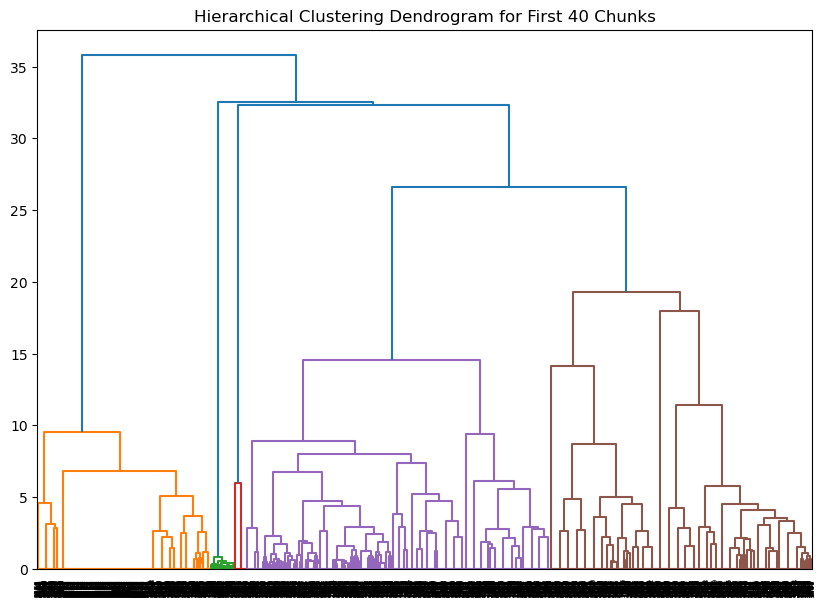

In [150]:
# Plotting the dendrogram
plt.figure(figsize=(10, 7))
plt.title(f'Hierarchical Clustering Dendrogram for First {num_chunks} Chunks')
dendrogram(linkage_matrix)
plt.show()

In [173]:
# Print each final cluster with its corresponding original words and exemplars
for label in np.unique(hierarchical_clusters):
    words_under_cluster = final_exemplars_words[label]
    cluster_points = final_exemplars_centroids[label]
    exemplar_point = find_exemplar(np.array(cluster_points))
    
    exemplar_word_index = np.where((combined_exemplars == exemplar_point).all(axis=1))[0][0]
    exemplar_word = combined_words[exemplar_word_index]
    
    words_str = ", ".join([f"{word}" for word in words_under_cluster])

    print(f"{exemplar_word}\n")

air

work

con

window

room

floor

bathroom

bath

shower

towel

water

wall

stain

tv

light

frustrating

park

car

coffee

machine

tea

none

didnt

downstairs

design

noise

lift

smell

look

lot

star

home

sign

system

check

way

point

receptionist

min

get

use

book

spa

pool

parking

experience

customer

hotel

sofitel

stay

morning

minute

flight

desk

front

day

manager

hour

time

reception

issue

people

night

door

’

phone

value

restaurant

food

drink

bar

service

charge

order

meal

lounge

rooftop

roof

terrace

choice

quality

breakfast

price

money

view

comfy

bed

size

location

airport

excellent

perfect

staff

access

convenient

street

gatwick

terminal

walk

area

clean

bit

city

facility

everything

london

amenity

departure



In [62]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [63]:

sia = SentimentIntensityAnalyzer()

In [190]:
aggregation_mapping = {
    'window': 'window',
    'floor': 'floor',
    'bathroom': 'bathroom',
    'shower': 'shower',
    'water': 'water',
    'wall': 'wall',
    'tv': 'tv',
    'light': 'light',
    'coffee': 'coffee',
    'tea': 'tea',
    'design': 'design',
    'noise': 'noise',
    'lift': 'lift',
    'smell': 'smell',
    'spa': 'spa',
    'pool': 'pool',
    'parking': 'parking',
    'flight': 'flight',
    'time': 'time',
    'reception': 'reception',
    'phone': 'phone',
    'restaurant': 'restaurant',
    'drink': 'drink',
    'bar': 'bar',
    'service': 'service',
    'charge': 'charge',
    'order': 'order',
    'meal': 'meal',
    'lounge': 'lounge',
    'roof': 'roof',
    'terrace': 'terrace',
    'price': 'price',
    'view': 'view',
    'comfy': 'comfy',
    'size': 'size',
    'access': 'access',
    'walk': 'walk',
    'area': 'area',
    'terminal':'terminal',
    'sign':'sign',
    'manager':'manager'
}

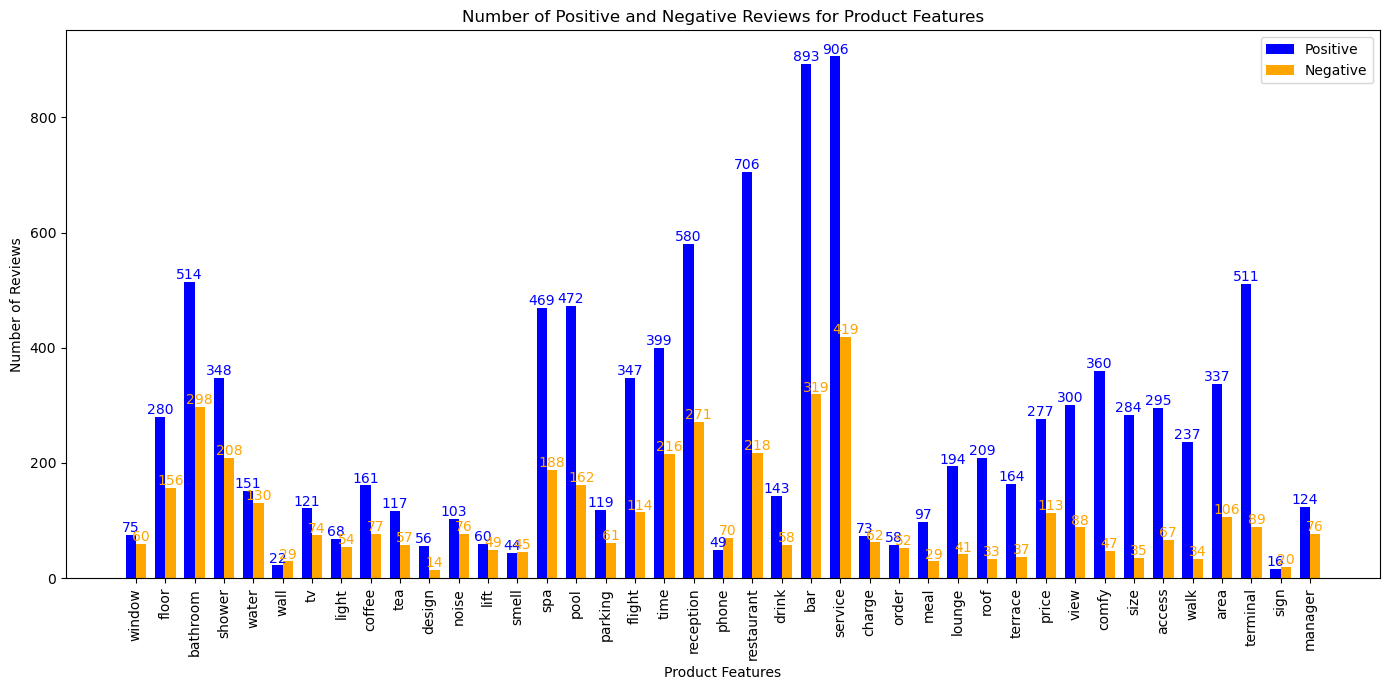

In [191]:
# Reverse mapping to check if a word belongs to a desired cluster
reverse_mapping = {}
for key, value in aggregation_mapping.items():
    if value not in reverse_mapping:
        reverse_mapping[value] = []
    reverse_mapping[value].append(key)
    
def analyze_sentiments_intersection(review):
    sentiments = {key: [] for key in reverse_mapping.keys()}
    sentences = nltk.sent_tokenize(review)
    for sentence in sentences:
        tokens = set(word_tokenize(sentence.lower()))
        for key, synonyms in reverse_mapping.items():
            if set(synonyms).intersection(tokens):
                sentiment = sia.polarity_scores(sentence)
                sentiments[key].append(sentiment['compound'])
    return sentiments

all_sentiments_intersection = review_column.apply(analyze_sentiments_intersection)

feature_sentiments_intersection = {key: [] for key in reverse_mapping.keys()}
for sentiments in all_sentiments_intersection:
    for feature, scores in sentiments.items():
        feature_sentiments_intersection[feature].extend(scores)

        positive_counts = {key: 0 for key in reverse_mapping.keys()}
negative_counts = {key: 0 for key in reverse_mapping.keys()}

for feature, scores in feature_sentiments_intersection.items():
    positive_counts[feature] = sum(1 for score in scores if score > 0)
    negative_counts[feature] = sum(1 for score in scores if score < 0)

# Plotting the bar graph
features = list(reverse_mapping.keys())
x = np.arange(len(features))

fig, ax = plt.subplots(figsize=(14, 7))

bar_width = 0.35
bar1 = ax.bar(x - bar_width/2, [positive_counts[feature] for feature in features], bar_width, label='Positive', color='blue')
bar2 = ax.bar(x + bar_width/2, [negative_counts[feature] for feature in features], bar_width, label='Negative', color='orange')

for i in range(len(features)):
    ax.text(x[i] - bar_width/2, positive_counts[features[i]] + 5, str(positive_counts[features[i]]), ha='center', color='blue')
    ax.text(x[i] + bar_width/2, negative_counts[features[i]] + 5, str(negative_counts[features[i]]), ha='center', color='orange')

ax.set_xlabel('Product Features')
ax.set_ylabel('Number of Reviews')
ax.set_title('Number of Positive and Negative Reviews for Product Features')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90)

ax.legend([bar1, bar2], ['Positive', 'Negative'])

plt.tight_layout()
plt.show()


In [193]:
# Ensuring all reviews are strings and handle missing values
data_reviews['Review'] = data_reviews['Review'].fillna('').astype(str)

sia = SentimentIntensityAnalyzer()

def sentiment_analysis(review):
    sentiment = sia.polarity_scores(review)
    return sentiment['compound']

data_reviews['Sentiment Score'] = data_reviews['Review'].apply(sentiment_analysis)

def label_reviews(score, sentiment):
    if score in range(1, 5):
        return 'negative'
    elif score in range(7, 11):
        return 'positive'
    elif score in range(5, 7):
        return 'positive' if sentiment > 0 else 'negative'

data_reviews['Label'] = [label_reviews(score, sentiment) for score, sentiment in zip(data_reviews['Review Score'], data_reviews['Sentiment Score'])]


In [194]:
data_reviews.head()

,Hotel Name,Reviewer Name,Hometown,Traveller Type,Room Type,Nights Stayed,Stayed Month,Reviewed Date,Review Title,Positive Feedback,Negative Feedback,Review Score,Review,Sentiment Score,Label
0,The Londoner,Chuvit,Thailand,Solo traveller,King Room,1 night,January 2024,3 January 2024,Front staff is very helpful and friendly. Even...,Even surrounding with tourist spot but inside ...,Breakfast need more varieties and 2 broken run...,10.0,Even surrounding with tourist spot but inside ...,0.9790,positive
1,The Londoner,Kay,United Kingdom,Couple,King Room,2 nights,May 2024,15 June 2024,Exceptional,Absolutely marvellous! Great choice too!,,10.0,Absolutely marvellous! Great choice too!,0.7151,positive
2,The Londoner,Eileen,United Kingdom,Couple,Deluxe King Room,3 nights,June 2024,14 June 2024,Very comfortable and very friendly staff.,Location is perfect for theatre land and food ...,,10.0,Location is perfect for theatre land and food ...,0.5719,positive
3,The Londoner,Andrai,United Kingdom,Couple,King Room,1 night,May 2024,11 June 2024,Beautiful and luxurious,Everything was amazing!,!,10.0,Everything was amazing! !,0.6580,positive
4,The Londoner,Carman,New Zealand,Solo traveller,Deluxe King Room,5 nights,June 2024,9 June 2024,I’ve found the place to stay on my London trips!!,Staff were great and the hotel facilities exce...,Tv guide was difficult to see what was on when...,10.0,Staff were great and the hotel facilities exce...,0.7430,positive


In [196]:
# Select the relevant columns
review_column = data_reviews['Review']
review_scores = data_reviews['Review Score']

# Define the features
features = ['window', 'floor', 'bathroom', 'shower', 'water', 'wall', 'tv', 'light', 'coffee', 
            'tea', 'design', 'noise', 'lift', 'smell', 'spa', 'pool', 'parking', 'flight', 'time', 
            'reception', 'phone', 'restaurant', 'drink', 'bar', 'charge', 'order','service'
            , 'meal', 'lounge', 'roof', 'terrace', 'price', 'view', 'comfy', 'size', 'access'
            , 'walk', 'area', 'terminal', 'sign', 'manager']



# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to extract and analyze sentiment of feature-related sentences
def analyze_feature_sentiments(review):
    sentences = sent_tokenize(review)
    feature_sentiments = {feature: [] for feature in features}
    for sentence in sentences:
        tokens = word_tokenize(sentence.lower())
        for feature in features:
            if feature in tokens:
                sentiment = sia.polarity_scores(sentence)
                feature_sentiments[feature].append(sentiment['compound'])
  
    average_feature_sentiments = {feature: np.mean(scores) if scores else 0 for feature, scores in feature_sentiments.items()}
    return average_feature_sentiments


sentiment_scores = review_column.apply(analyze_feature_sentiments)


sentiment_df = pd.DataFrame(sentiment_scores.tolist())

sentiment_df['total_sentiment_score'] = sentiment_df.mean(axis=1)

data_reviews = pd.concat([data_reviews, sentiment_df], axis=1)

print(data_reviews[features + ['total_sentiment_score']])

       window  floor  bathroom  shower   water  wall      tv  light  coffee  \
0         0.0    0.0       0.0     0.0  0.0000   0.0  0.0000    0.0     0.0   
1         0.0    0.0       0.0     0.0  0.0000   0.0  0.0000    0.0     0.0   
2         0.0    0.0       0.0     0.0  0.0000   0.0  0.0000    0.0     0.0   
3         0.0    0.0       0.0     0.0  0.0000   0.0  0.0000    0.0     0.0   
4         0.0    0.0       0.0     0.0  0.0000   0.0 -0.3612    0.0     0.0   
...       ...    ...       ...     ...     ...   ...     ...    ...     ...   
11571     0.0    0.0       0.0     0.0  0.0000   0.0  0.0000    0.0     0.0   
11572     0.0    0.0       0.0     0.0  0.0000   0.0  0.0000    0.0     0.0   
11573     0.0    0.0       0.0     0.0  0.0000   0.0  0.0000    0.0     0.0   
11574     0.0    0.0       0.0     0.0  0.0000   0.0  0.0000    0.0     0.0   
11575     0.0    0.0       0.0     0.0 -0.0249   0.0  0.0000    0.0     0.0   

       tea  ...  view  comfy  size  access  walk  a

In [197]:
data_reviews.iloc[:, 13:]


,Sentiment Score,Label,window,floor,bathroom,shower,water,wall,tv,light,...,view,comfy,size,access,walk,area,terminal,sign,manager,total_sentiment_score
0,0.9790,positive,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043220
1,0.7151,positive,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.5719,positive,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013949
3,0.6580,positive,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.7430,positive,0.0,0.0,0.0,0.0,0.0000,0.0,-0.3612,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.008810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11571,0.4404,positive,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11572,0.5859,positive,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11573,0.5209,positive,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11574,-0.9001,negative,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.022715


In [198]:
# Create a new variable for numerical labels
data_reviews['Numerical Label'] = data_reviews['Label'].map({'negative': 0, 'positive': 1})

nan_count = data_reviews['Numerical Label'].isna().sum()
print(f"Number of NaN values in y: {nan_count}")


data_reviews = data_reviews.dropna(subset=['Numerical Label'])

X = data_reviews[features]
y = data_reviews['Numerical Label']

Number of NaN values in y: 8


In [199]:
data_reviews_clean = data_reviews.dropna(subset=['Numerical Label'])

X = data_reviews_clean[features].dropna()
y = data_reviews_clean['Numerical Label']

In [200]:
X

,window,floor,bathroom,shower,water,wall,tv,light,coffee,tea,...,price,view,comfy,size,access,walk,area,terminal,sign,manager
0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0000,0.0,-0.3612,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11571,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11572,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11573,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11574,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
X.to_csv("X_data")

In [202]:
y

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
11571    1.0
11572    1.0
11573    1.0
11574    0.0
11575    1.0
Name: Numerical Label, Length: 11568, dtype: float64

In [170]:
y.to_csv("y_data")

In [212]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

X = np.array(X)
y = np.array(y)

K = 5
K_prime = 5

kf_outer = KFold(n_splits=K, shuffle=True, random_state=42)

param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}

f1_scores_outer = []

for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X), start=1):
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    print(f"\nOuter Fold K={outer_fold}")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")

    kf_inner = KFold(n_splits=K_prime, shuffle=True, random_state=42)

    f1_scores_inner_test = []

    for inner_fold, (train_index_inner, val_index_inner) in enumerate(kf_inner.split(X_train_outer), start=1):
        X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
        y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]

        best_f1_inner = -1
        best_params = None
        best_model = None

        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
               
                clf.fit(X_train_inner, y_train_inner)
                
                y_pred_inner = clf.predict(X_val_inner)
                f1_inner = f1_score(y_val_inner, y_pred_inner, pos_label=1, average='binary')

                if f1_inner > best_f1_inner:
                    best_f1_inner = f1_inner
                    best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
                    best_model = clf

        y_pred_inner_test = best_model.predict(X_test_outer)
        f1_inner_test = f1_score(y_test_outer, y_pred_inner_test, pos_label=1, average='binary')
        f1_scores_inner_test.append(f1_inner_test)

        print(f"  Inner Fold K'={inner_fold}/{K_prime}, Best F1 Score on Validation: {best_f1_inner}, Best Params: {best_params}")
        print(f"    Train indices: {train_index_inner}")
        print(f"    Validation indices: {val_index_inner}")

    average_f1_inner_test = np.mean(f1_scores_inner_test)
    f1_scores_outer.append(average_f1_inner_test)

    print(f"Outer Fold K={outer_fold}/{K}, Average F1 Score on Outer Test Data: {average_f1_inner_test}")

average_f1_score_outer = np.mean(f1_scores_outer)
print("\nF1 Scores for each outer fold:", f1_scores_outer)
print("Average F1 Score across all outer folds:", average_f1_score_outer)



Outer Fold K=1
Train indices: [    1     2     4 ... 11564 11565 11567]
Test indices: [    0     3     8 ... 11552 11560 11566]
  Inner Fold K'=1/5, Best F1 Score on Validation: 0.9336424224862361, Best Params: {'max_depth': 3, 'min_samples_split': 2}
    Train indices: [   1    2    3 ... 9250 9251 9253]
    Validation indices: [   0    8   12 ... 9243 9247 9252]
  Inner Fold K'=2/5, Best F1 Score on Validation: 0.9323572474377744, Best Params: {'max_depth': 10, 'min_samples_split': 5}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [   3   15   26 ... 9244 9249 9250]
  Inner Fold K'=3/5, Best F1 Score on Validation: 0.9274264062955406, Best Params: {'max_depth': 3, 'min_samples_split': 2}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [  24   25   29 ... 9239 9245 9246]
  Inner Fold K'=4/5, Best F1 Score on Validation: 0.9186490455212921, Best Params: {'max_depth': 3, 'min_samples_split': 2}
    Train indices: [   0    1

In [214]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


X = np.array(X)
y = np.array(y)

K = 5
K_prime = 5

kf_outer = KFold(n_splits=K, shuffle=True, random_state=42)

param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}

f1_scores_outer = []

# Outer loop
for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X), start=1):
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    print(f"\nOuter Fold K={outer_fold}")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")

    kf_inner = KFold(n_splits=K_prime, shuffle=True, random_state=42)

    f1_scores_inner_test = []

    for inner_fold, (train_index_inner, val_index_inner) in enumerate(kf_inner.split(X_train_outer), start=1):
        X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
        y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]

        best_f1_inner = -1
        best_params = None
        best_model = None

        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                clf = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)

                clf.fit(X_train_inner, y_train_inner)

                y_pred_inner = clf.predict(X_val_inner)
                f1_inner = f1_score(y_val_inner, y_pred_inner, pos_label=1, average='binary')

                if f1_inner > best_f1_inner:
                    best_f1_inner = f1_inner
                    best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
                    best_model = clf

        y_pred_inner_test = best_model.predict(X_test_outer)
        f1_inner_test = f1_score(y_test_outer, y_pred_inner_test, pos_label=1, average='binary')
        f1_scores_inner_test.append(f1_inner_test)

        print(f"  Inner Fold K'={inner_fold}/{K_prime}, Best F1 Score on Validation: {best_f1_inner}, Best Params: {best_params}")
        print(f"    Train indices: {train_index_inner}")
        print(f"    Validation indices: {val_index_inner}")

    average_f1_inner_test = np.mean(f1_scores_inner_test)
    f1_scores_outer.append(average_f1_inner_test)

    print(f"Outer Fold K={outer_fold}/{K}, Average F1 Score on Outer Test Data: {average_f1_inner_test}")

average_f1_score_outer = np.mean(f1_scores_outer)
print("\nF1 Scores for each outer fold:", f1_scores_outer)
print("Average F1 Score across all outer folds:", average_f1_score_outer)



Outer Fold K=1
Train indices: [    1     2     4 ... 11564 11565 11567]
Test indices: [    0     3     8 ... 11552 11560 11566]
  Inner Fold K'=1/5, Best F1 Score on Validation: 0.9360230547550432, Best Params: {'max_depth': 7, 'min_samples_split': 5}
    Train indices: [   1    2    3 ... 9250 9251 9253]
    Validation indices: [   0    8   12 ... 9243 9247 9252]
  Inner Fold K'=2/5, Best F1 Score on Validation: 0.9348015068096204, Best Params: {'max_depth': 10, 'min_samples_split': 5}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [   3   15   26 ... 9244 9249 9250]
  Inner Fold K'=3/5, Best F1 Score on Validation: 0.928405122235157, Best Params: {'max_depth': 10, 'min_samples_split': 5}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [  24   25   29 ... 9239 9245 9246]
  Inner Fold K'=4/5, Best F1 Score on Validation: 0.9202346041055719, Best Params: {'max_depth': 7, 'min_samples_split': 5}
    Train indices: [   0    1

In [228]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import lightgbm as lgb
import numpy as np

K = 5
K_prime = 5

kf_outer = KFold(n_splits=K, shuffle=False)

f1_scores = []


for outer_fold, (train_index_outer, test_index_outer) in enumerate(kf_outer.split(X), start=1):
    X_train_outer, X_test_outer = X[train_index_outer], X[test_index_outer]
    y_train_outer, y_test_outer = y[train_index_outer], y[test_index_outer]

    kf_inner = KFold(n_splits=K_prime, shuffle=False)

    inner_f1_scores = []

    for inner_fold, (train_index_inner, val_index_inner) in enumerate(kf_inner.split(X_train_outer), start=1):
        X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
        y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]

        clf = lgb.LGBMClassifier(random_state=42, verbosity=-1)
        clf.fit(X_train_inner, y_train_inner)

        y_pred_inner = clf.predict(X_val_inner)

        f1_inner = f1_score(y_val_inner, y_pred_inner, pos_label=1, average='binary')
        inner_f1_scores.append(f1_inner)

        print(f"Outer Fold K={outer_fold}/{K}, Inner Fold K'={inner_fold}/{K_prime}, Inner F1 Score: {f1_inner}")

    clf.fit(X_train_outer, y_train_outer)
    y_pred_outer = clf.predict(X_test_outer)

    f1_outer = f1_score(y_test_outer, y_pred_outer, pos_label=1, average='binary')
    f1_scores.append(f1_outer)
    print(f"Outer Fold K={outer_fold}/{K}, Outer F1 Score: {f1_outer}")

average_f1_score = np.mean(f1_scores)
print("\nF1 Scores for each outer fold:", f1_scores)
print("Average F1 Score:", average_f1_score)


Outer Fold K=1/5, Inner Fold K'=1/5, Inner F1 Score: 0.8634162092347433
Outer Fold K=1/5, Inner Fold K'=2/5, Inner F1 Score: 0.980996970531534
Outer Fold K=1/5, Inner Fold K'=3/5, Inner F1 Score: 0.9818481848184819
Outer Fold K=1/5, Inner Fold K'=4/5, Inner F1 Score: 0.8073211314475874
Outer Fold K=1/5, Inner Fold K'=5/5, Inner F1 Score: 0.8960396039603961
Outer Fold K=1/5, Outer F1 Score: 0.9595297309518427
Outer Fold K=2/5, Inner Fold K'=1/5, Inner F1 Score: 0.9675615212527965
Outer Fold K=2/5, Inner Fold K'=2/5, Inner F1 Score: 0.9854754727322554
Outer Fold K=2/5, Inner Fold K'=3/5, Inner F1 Score: 0.9876948318293683
Outer Fold K=2/5, Inner Fold K'=4/5, Inner F1 Score: 0.801831262262917
Outer Fold K=2/5, Inner Fold K'=5/5, Inner F1 Score: 0.8978234582829504
Outer Fold K=2/5, Outer F1 Score: 0.8869179600886918
Outer Fold K=3/5, Inner Fold K'=1/5, Inner F1 Score: 0.9570412517780938
Outer Fold K=3/5, Inner Fold K'=2/5, Inner F1 Score: 0.909368324687214
Outer Fold K=3/5, Inner Fold K'=3

In [217]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

K = 5
K_prime = 5

kf_outer = KFold(n_splits=K, shuffle=True, random_state=42)

param_grid = {'depth': [3, 5, 7, 10], 'iterations': [100, 200, 300]}

f1_scores_outer = []

for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X), start=1):
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    print(f"\nOuter Fold K={outer_fold}")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")

    kf_inner = KFold(n_splits=K_prime, shuffle=True, random_state=42)

    f1_scores_inner_test = []

    for inner_fold, (train_index_inner, val_index_inner) in enumerate(kf_inner.split(X_train_outer), start=1):
        X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
        y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]

        best_f1_inner = -1
        best_params = None
        best_model = None

        for depth in param_grid['depth']:
            for iterations in param_grid['iterations']:

                clf = CatBoostClassifier(depth=depth, iterations=iterations, random_seed=42, verbose=0)
               
                clf.fit(X_train_inner, y_train_inner)
               
                y_pred_inner = clf.predict(X_val_inner)
                f1_inner = f1_score(y_val_inner, y_pred_inner, pos_label=1, average='binary')

                if f1_inner > best_f1_inner:
                    best_f1_inner = f1_inner
                    best_params = {'depth': depth, 'iterations': iterations}
                    best_model = clf

        y_pred_inner_test = best_model.predict(X_test_outer)
        f1_inner_test = f1_score(y_test_outer, y_pred_inner_test, pos_label=1, average='binary')
        f1_scores_inner_test.append(f1_inner_test)

        print(f"  Inner Fold K'={inner_fold}/{K_prime}, Best F1 Score on Validation: {best_f1_inner}, Best Params: {best_params}")
        print(f"    Train indices: {train_index_inner}")
        print(f"    Validation indices: {val_index_inner}")

    average_f1_inner_test = np.mean(f1_scores_inner_test)
    f1_scores_outer.append(average_f1_inner_test)

    print(f"Outer Fold K={outer_fold}/{K}, Average F1 Score on Outer Test Data: {average_f1_inner_test}")

average_f1_score_outer = np.mean(f1_scores_outer)
print("\nF1 Scores for each outer fold:", f1_scores_outer)
print("Average F1 Score across all outer folds:", average_f1_score_outer)



Outer Fold K=1
Train indices: [    1     2     4 ... 11564 11565 11567]
Test indices: [    0     3     8 ... 11552 11560 11566]
  Inner Fold K'=1/5, Best F1 Score on Validation: 0.9345359324992725, Best Params: {'depth': 3, 'iterations': 300}
    Train indices: [   1    2    3 ... 9250 9251 9253]
    Validation indices: [   0    8   12 ... 9243 9247 9252]
  Inner Fold K'=2/5, Best F1 Score on Validation: 0.9344262295081968, Best Params: {'depth': 7, 'iterations': 100}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [   3   15   26 ... 9244 9249 9250]
  Inner Fold K'=3/5, Best F1 Score on Validation: 0.9290322580645162, Best Params: {'depth': 3, 'iterations': 300}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [  24   25   29 ... 9239 9245 9246]
  Inner Fold K'=4/5, Best F1 Score on Validation: 0.9185628742514971, Best Params: {'depth': 10, 'iterations': 100}
    Train indices: [   0    1    2 ... 9250 9251 9252]
    Valida

In [216]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import xgboost as xgb

K = 5
K_prime = 5
kf_outer = KFold(n_splits=K, shuffle=True, random_state=42)

param_grid = {'max_depth': [3, 5, 7, 10], 'min_child_weight': [1, 3, 5]}

f1_scores_outer = []

for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X), start=1):
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    print(f"\nOuter Fold K={outer_fold}")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")

    kf_inner = KFold(n_splits=K_prime, shuffle=True, random_state=42)

    f1_scores_inner_test = []

    for inner_fold, (train_index_inner, val_index_inner) in enumerate(kf_inner.split(X_train_outer), start=1):
        X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
        y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]

        best_f1_inner = -1
        best_params = None
        best_model = None

        for max_depth in param_grid['max_depth']:
            for min_child_weight in param_grid['min_child_weight']:
                clf = xgb.XGBClassifier(max_depth=max_depth, min_child_weight=min_child_weight, eval_metric='logloss', random_state=42)
        
                clf.fit(X_train_inner, y_train_inner)

                y_pred_inner = clf.predict(X_val_inner)
                f1_inner = f1_score(y_val_inner, y_pred_inner, pos_label=1, average='binary')

                if f1_inner > best_f1_inner:
                    best_f1_inner = f1_inner
                    best_params = {'max_depth': max_depth, 'min_child_weight': min_child_weight}
                    best_model = clf

        y_pred_inner_test = best_model.predict(X_test_outer)
        f1_inner_test = f1_score(y_test_outer, y_pred_inner_test, pos_label=1, average='binary')
        f1_scores_inner_test.append(f1_inner_test)

        print(f"  Inner Fold K'={inner_fold}/{K_prime}, Best F1 Score on Validation: {best_f1_inner}, Best Params: {best_params}")
        print(f"    Train indices: {train_index_inner}")
        print(f"    Validation indices: {val_index_inner}")

    average_f1_inner_test = np.mean(f1_scores_inner_test)
    f1_scores_outer.append(average_f1_inner_test)

    print(f"Outer Fold K={outer_fold}/{K}, Average F1 Score on Outer Test Data: {average_f1_inner_test}")

average_f1_score_outer = np.mean(f1_scores_outer)
print("\nF1 Scores for each outer fold:", f1_scores_outer)
print("Average F1 Score across all outer folds:", average_f1_score_outer)



Outer Fold K=1
Train indices: [    1     2     4 ... 11564 11565 11567]
Test indices: [    0     3     8 ... 11552 11560 11566]
  Inner Fold K'=1/5, Best F1 Score on Validation: 0.9350497366881217, Best Params: {'max_depth': 3, 'min_child_weight': 5}
    Train indices: [   1    2    3 ... 9250 9251 9253]
    Validation indices: [   0    8   12 ... 9243 9247 9252]
  Inner Fold K'=2/5, Best F1 Score on Validation: 0.9352475827717549, Best Params: {'max_depth': 7, 'min_child_weight': 3}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [   3   15   26 ... 9244 9249 9250]
  Inner Fold K'=3/5, Best F1 Score on Validation: 0.9297265510144075, Best Params: {'max_depth': 3, 'min_child_weight': 3}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [  24   25   29 ... 9239 9245 9246]
  Inner Fold K'=4/5, Best F1 Score on Validation: 0.9189835575485801, Best Params: {'max_depth': 3, 'min_child_weight': 3}
    Train indices: [   0    1    2

In [37]:
data = {
    'DecisionTree': {
        'Inner F1 Scores': [
            [0.9336424224862361, 0.9323572474377744, 0.9274264062955406, 0.9186490455212921, 0.9284051222351571],
            [0.9310445155659004, 0.9322524609148812, 0.9302461899179367, 0.9297736506094022, 0.9184523809523809],
            [0.9345740040709508, 0.9301919720767889, 0.9271137026239068, 0.9289681379713534, 0.9269859813084111],
            [0.933177706448789, 0.9333333333333332, 0.9326364692218351, 0.9281542056074766, 0.9268434858641795],
            [0.9360583941605839, 0.9345740040709508, 0.9295039164490861, 0.9236172080772608, 0.9268867924528302]
        ],
        'Outer F1 Averages': [0.9345865930014619, 0.9285108890884647, 0.9307843157422383, 0.9213546367832546, 0.9280134640841913]
    },
    'RandomForest': {
        'Inner F1 Scores': [
            [0.9360230547550432, 0.9348015068096204, 0.928405122235157, 0.9202346041055719, 0.929732868757259],
            [0.9331403762662807, 0.9329091960670907, 0.9310943833236828, 0.9303135888501743, 0.9225372698041509],
            [0.9353435778486517, 0.9319826338639653, 0.9271716876279614, 0.9284883720930233, 0.9281122150789012],
            [0.9348769898697539, 0.9343696027633852, 0.9344547563805103, 0.9292988070992144, 0.9293399243966269],
            [0.9374275782155271, 0.9354094579008074, 0.930151338766007, 0.9271137026239067, 0.9255474452554744]
        ],
        'Outer F1 Averages': [0.9348383895392928, 0.9313041696304604, 0.9314034106383648, 0.9227962240066334, 0.928993562318866]
    },
    'CatBoost': {
        'Inner F1 Scores': [
            [0.9345359324992725, 0.9344262295081968, 0.9290322580645162, 0.9185628742514971, 0.929245283018868],
            [0.9306526806526807, 0.9337613072658302, 0.9325117370892018, 0.9323131253678635, 0.9237641453245979],
            [0.9337260677466862, 0.933920704845815, 0.928697701826753, 0.9298349056603773, 0.9283599763173475],
            [0.9368051492100643, 0.9340723453908985, 0.9363689433741973, 0.9336075205640424, 0.9270588235294118],
            [0.9377375036539023, 0.9308836395450568, 0.9318785019168387, 0.9269580522147257, 0.9255759007678677]
        ],
        'Outer F1 Averages': [0.9337493048796418, 0.9310312940153862, 0.9306605561711757, 0.9219859141102564, 0.928472982402518]
    },
    'XGBoost': {
        'Inner F1 Scores': [
            [0.9350497366881217, 0.9352475827717549, 0.9297265510144075, 0.9189835575485801, 0.9296187683284458],
            [0.9315712187958884, 0.9328248753300089, 0.9328642626795661, 0.9312887053966382, 0.9232137563000297],
            [0.9350877192982456, 0.9308620182406591, 0.9280190362879239, 0.9295193158360366, 0.9284447072738023],
            [0.9371895997662869, 0.934469585659712, 0.9371895997662868, 0.9303964757709251, 0.9265703332350338],
            [0.9375915616759449, 0.9320388349514565, 0.9325443786982249, 0.9268867924528301, 0.9255759007678677]
        ],
        'Outer F1 Averages': [0.9356110974500998, 0.9306005427221333, 0.9301884501071596, 0.9211195048647864, 0.930224607302474]
    },
    'LightGBM': {
        'Inner F1 Scores': [
            [0.8634162092347433, 0.980996970531534, 0.9818481848184819, 0.8073211314475874, 0.8960396039603961],
            [0.9675615212527965, 0.9854754727322554, 0.9876948318293683, 0.801831262262917, 0.8978234582829504],
            [0.9570412517780938, 0.909368324687214, 0.9433962264150944, 0.8099999999999999, 0.895595934708962],
            [0.9619611158072697, 0.9047044632086851, 0.9549086757990868, 0.9899045020463848, 0.8995157384987894],
            [0.955308852832337, 0.903206106870229, 0.9464594127806564, 0.9851973684210525, 0.811965811965812]
        ],
        'Outer F1 Averages': [0.9595297309518427, 0.8869179600886918, 0.9850877192982457, 0.856135046611237, 0.9122045344910757]
    }
}

outer_folds = ['1', '2', '3', '4', '5']
inner_folds = [f"{i+1}''" for i in range(5)]
columns = pd.MultiIndex.from_product([outer_folds, inner_folds + ['Avg']], names=['Outer Fold', 'Inner Fold'])

df = pd.DataFrame(index=columns, columns=data.keys())

for model, scores in data.items():
    inner_f1_scores = scores['Inner F1 Scores']
    outer_f1_averages = scores['Outer F1 Averages']
    
    for i, outer_fold in enumerate(outer_folds):
        combined_scores = inner_f1_scores[i] + [outer_f1_averages[i]]
        df.loc[(outer_fold,), model] = combined_scores


df = df.reset_index()

final_avg_scores = {model: df[model][df['Inner Fold'] == 'Avg'].mean() for model in data.keys()}

final_row = pd.DataFrame([['Final Avg', ''] + list(final_avg_scores.values())], columns=df.columns)
df = pd.concat([df, final_row], ignore_index=True)

df.loc[df['Outer Fold'].duplicated(), 'Outer Fold'] = ''



In [38]:
df

,Outer Fold,Inner Fold,DecisionTree,RandomForest,CatBoost,XGBoost,LightGBM
0,1,1'',0.933642,0.936023,0.934536,0.93505,0.863416
1,,2'',0.932357,0.934802,0.934426,0.935248,0.980997
2,,3'',0.927426,0.928405,0.929032,0.929727,0.981848
3,,4'',0.918649,0.920235,0.918563,0.918984,0.807321
4,,5'',0.928405,0.929733,0.929245,0.929619,0.89604
5,,Avg,0.934587,0.934838,0.933749,0.935611,0.95953
6,2,1'',0.931045,0.93314,0.930653,0.931571,0.967562
7,,2'',0.932252,0.932909,0.933761,0.932825,0.985475
8,,3'',0.930246,0.931094,0.932512,0.932864,0.987695
9,,4'',0.929774,0.930314,0.932313,0.931289,0.801831


In [203]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


X = np.array(X)
y = np.array(y)

K = 5
K_prime = 5

kf_outer = KFold(n_splits=K, shuffle=True, random_state=42)

param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}

f1_scores_outer = []

all_models = []
all_f1_scores = []
all_shap_values = np.zeros(X.shape)  

for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X), start=1):
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    print(f"\nOuter Fold K={outer_fold}")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")

    kf_inner = KFold(n_splits=K_prime, shuffle=True, random_state=42)

    f1_scores_inner_test = []
    shap_values_inner_test = np.zeros(X_test_outer.shape)  


    for inner_fold, (train_index_inner, val_index_inner) in enumerate(kf_inner.split(X_train_outer), start=1):
        X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
        y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]

     
        best_f1_inner = -1
        best_params = None
        best_model = None

        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                
                clf = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
               
         
                clf.fit(X_train_inner, y_train_inner)
               
               
                y_pred_inner = clf.predict(X_val_inner)
                f1_inner = f1_score(y_val_inner, y_pred_inner, pos_label=1, average='binary')

                if f1_inner > best_f1_inner:
                    best_f1_inner = f1_inner
                    best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
                    best_model = clf

        all_models.append(best_model)
        all_f1_scores.append(best_f1_inner)

        y_pred_inner_test = best_model.predict(X_test_outer)
        f1_inner_test = f1_score(y_test_outer, y_pred_inner_test, pos_label=1, average='binary')
        f1_scores_inner_test.append(f1_inner_test)

        explainer = shap.TreeExplainer(best_model)
        shap_values = (explainer.shap_values(X_test_outer))  
        shap_values_reduced = shap_values[:, :, 0]
        shap_values_abs = np.abs(shap_values_reduced)


        shap_values_inner_test += shap_values_abs * f1_inner_test

        print(f"  Inner Fold K'={inner_fold}/{K_prime}, Best F1 Score on Validation: {best_f1_inner}, Best Params: {best_params}")
        print(f"    Train indices: {train_index_inner}")
        print(f"    Validation indices: {val_index_inner}")


    average_f1_inner_test = np.mean(f1_scores_inner_test)
    f1_scores_outer.append(average_f1_inner_test)


    shap_values_inner_test /= np.sum(f1_scores_inner_test)

    all_shap_values[test_index] = shap_values_inner_test

    print(f"Outer Fold K={outer_fold}/{K}, Average F1 Score on Outer Test Data: {average_f1_inner_test}")

average_f1_score_outer = np.mean(f1_scores_outer)
print("\nF1 Scores for each outer fold:", f1_scores_outer)
print("Average F1 Score across all outer folds:", average_f1_score_outer)

shap_df = pd.DataFrame(all_shap_values, columns=[f"Feature_{i+1}" for i in range(X.shape[1])])

print("\nSHAP Values DataFrame:")
print(shap_df)



Outer Fold K=1
Train indices: [    1     2     4 ... 11564 11565 11567]
Test indices: [    0     3     8 ... 11552 11560 11566]
  Inner Fold K'=1/5, Best F1 Score on Validation: 0.9360230547550432, Best Params: {'max_depth': 7, 'min_samples_split': 5}
    Train indices: [   1    2    3 ... 9250 9251 9253]
    Validation indices: [   0    8   12 ... 9243 9247 9252]
  Inner Fold K'=2/5, Best F1 Score on Validation: 0.9348015068096204, Best Params: {'max_depth': 10, 'min_samples_split': 5}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [   3   15   26 ... 9244 9249 9250]
  Inner Fold K'=3/5, Best F1 Score on Validation: 0.928405122235157, Best Params: {'max_depth': 10, 'min_samples_split': 5}
    Train indices: [   0    1    2 ... 9251 9252 9253]
    Validation indices: [  24   25   29 ... 9239 9245 9246]
  Inner Fold K'=4/5, Best F1 Score on Validation: 0.9202346041055719, Best Params: {'max_depth': 7, 'min_samples_split': 5}
    Train indices: [   0    1

In [204]:

shap_df.columns = features

In [205]:
shap_df

,window,floor,bathroom,shower,water,wall,tv,light,coffee,tea,...,price,view,comfy,size,access,walk,area,terminal,sign,manager
0,0.000686,0.001829,0.002831,0.001788,0.001104,0.000132,0.000168,0.000294,0.000435,0.000056,...,0.000848,0.000439,0.000143,0.000145,0.000352,0.000095,0.000284,0.000571,0.000012,0.002065
1,0.000102,0.001364,0.003367,0.001400,0.000892,0.000042,0.000180,0.000243,0.000106,0.000066,...,0.000355,0.000613,0.000109,0.000043,0.000042,0.000028,0.000056,0.000350,0.000029,0.000813
2,0.000156,0.000935,0.002928,0.001157,0.000499,0.000020,0.000121,0.000258,0.000133,0.000026,...,0.000541,0.000491,0.000158,0.000030,0.000034,0.000014,0.000127,0.000311,0.000011,0.000726
3,0.000287,0.001642,0.003590,0.001451,0.000727,0.000019,0.000229,0.000179,0.000114,0.000073,...,0.000200,0.000634,0.000061,0.000018,0.000028,0.000025,0.000015,0.000398,0.000013,0.000832
4,0.000098,0.001278,0.002995,0.001238,0.000836,0.000068,0.034709,0.000240,0.000215,0.000302,...,0.000450,0.000972,0.000345,0.000141,0.000062,0.000078,0.000278,0.000480,0.000191,0.001094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,0.000141,0.001538,0.004348,0.000975,0.001215,0.000056,0.000192,0.000245,0.000203,0.000098,...,0.000441,0.000468,0.000087,0.000030,0.000051,0.000025,0.000043,0.000797,0.000034,0.000821
11564,0.000141,0.001538,0.004348,0.000975,0.001215,0.000056,0.000192,0.000245,0.000203,0.000098,...,0.000441,0.000468,0.000087,0.000030,0.000051,0.000025,0.000043,0.000797,0.000034,0.000821
11565,0.000102,0.001364,0.003367,0.001400,0.000892,0.000042,0.000180,0.000243,0.000106,0.000066,...,0.000355,0.000613,0.000109,0.000043,0.000042,0.000028,0.000056,0.000350,0.000029,0.000813
11566,0.000287,0.001309,0.003551,0.001412,0.000717,0.000019,0.000224,0.000175,0.000112,0.000073,...,0.000341,0.000624,0.000061,0.000018,0.000029,0.000025,0.000021,0.000379,0.000013,0.000816


In [206]:
shap_df.to_csv('shap2_data.csv')

In [48]:
import pandas as pd
from sklearn.model_selection import KFold

Z = pd.DataFrame()

K = 5

kf_outer = KFold(n_splits=K, shuffle=True, random_state=42)

for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X), start=1):

    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]
    
    X_test_outer_df = pd.DataFrame(X_test_outer)
    
    Z = pd.concat([Z, X_test_outer_df], ignore_index=True)
    

In [206]:
Z.columns = features

In [199]:
Z

,window,room,clean,bathroom,toilet,tv,park,car,parking,coffee,...,restaurant,bar,lounge,roof,terrace,quality,price,bed,location,cluster
0,0.0,0.0000,0.9749,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.9749,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,392
1,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0
2,0.0,0.0000,0.0000,0.0,-0.2006,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,311
3,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,149
4,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,1379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,0.0,0.9573,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.9573,7
11564,0.0,-0.4767,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,-0.4767,426
11565,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,201
11566,0.0,0.6114,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.6114,0.0000,561


In [49]:
Z.to_csv('Z_data')

In [3]:
import pandas as pd
shap_df=pd.read_csv(r'shap2_data.csv')

In [4]:
shap_df=shap_df.drop(columns=['Unnamed: 0'])

In [5]:
shap_df.columns

Index(['window', 'floor', 'bathroom', 'shower', 'water', 'wall', 'tv', 'light',
       'coffee', 'tea', 'design', 'noise', 'lift', 'smell', 'spa', 'pool',
       'parking', 'flight', 'time', 'reception', 'phone', 'restaurant',
       'drink', 'bar', 'charge', 'order', 'service', 'meal', 'lounge', 'roof',
       'terrace', 'price', 'view', 'comfy', 'size', 'access', 'walk', 'area',
       'terminal', 'sign', 'manager'],
      dtype='object')

In [6]:
temp=shap_df

In [25]:
temp.describe()

,window,floor,bathroom,shower,water,wall,tv,light,coffee,tea,...,view,comfy,size,access,walk,area,terminal,sign,manager,cluster_labels_kmeans
count,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,...,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000
mean,0.000366,0.002413,0.006628,0.002675,0.001581,0.000066,0.000372,0.000441,0.000290,0.000131,...,0.001085,0.000337,0.000127,0.000157,0.000078,0.000232,0.001142,0.000037,0.001454,14.993517
std,0.003266,0.011131,0.024028,0.010483,0.008365,0.000487,0.002267,0.003329,0.001977,0.001395,...,0.007056,0.002160,0.000867,0.000813,0.000474,0.001930,0.008763,0.000423,0.009490,39.272317
min,0.000038,0.000162,0.000538,0.000179,0.000234,0.000005,0.000036,0.000055,0.000020,0.000011,...,0.000062,0.000030,0.000011,0.000017,0.000005,0.000008,0.000082,0.000002,0.000154,0.000000
25%,0.000141,0.000919,0.003049,0.001158,0.000637,0.000019,0.000173,0.000186,0.000106,0.000050,...,0.000479,0.000087,0.000030,0.000034,0.000014,0.000024,0.000311,0.000011,0.000724,0.000000
50%,0.000155,0.001364,0.003367,0.001400,0.000727,0.000025,0.000180,0.000242,0.000117,0.000066,...,0.000506,0.000134,0.000033,0.000047,0.000025,0.000055,0.000350,0.000013,0.000804,0.000000
75%,0.000266,0.001538,0.003729,0.001606,0.000934,0.000056,0.000215,0.000249,0.000203,0.000098,...,0.000625,0.000169,0.000043,0.000051,0.000028,0.000127,0.000685,0.000033,0.000829,0.000000
max,0.127416,0.181981,0.356635,0.146207,0.158472,0.029409,0.053541,0.117045,0.063690,0.070595,...,0.186956,0.070579,0.040113,0.033503,0.028393,0.075052,0.256433,0.025869,0.210048,199.000000


In [8]:
Z_data=pd.read_csv(r'Z_data.csv')

In [9]:
Z_data.columns

Index(['Unnamed: 0', 'window', 'floor', 'bathroom', 'shower', 'water', 'wall',
       'tv', 'light', 'coffee', 'tea', 'design', 'noise', 'lift', 'smell',
       'spa', 'pool', 'parking', 'flight', 'time', 'reception', 'phone',
       'restaurant', 'drink', 'bar', 'charge', 'order', 'service', 'meal',
       'lounge', 'roof', 'terrace', 'price', 'view', 'comfy', 'size', 'access',
       'walk', 'area', 'terminal', 'sign', 'manager'],
      dtype='object')

In [10]:
Z_data=Z_data.drop(columns=['Unnamed: 0'])

In [11]:
S=pd.read_csv('s.csv')

In [12]:
S=S.drop(columns=['Unnamed: 0'])

In [13]:
S

,Review Score
0,10.0
1,10.0
2,10.0
3,10.0
4,10.0
...,...
11563,10.0
11564,5.0
11565,10.0
11566,10.0


In [35]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
shap_df_scaled = scaler.fit_transform(temp.drop(columns=[]))  # Adjust as needed

num_clusters = 200
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(shap_df_scaled)

temp['cluster_labels_kmeans'] = cluster_labels
Z_data['cluster_labels_kmeans'] = cluster_labels
S['cluster_labels_kmeans'] = cluster_labels

df_highest_opportunity = pd.DataFrame(columns=['Cluster', 'Feature', 'Avg Importance', 'Avg Satisfaction', 'Opportunity', 'Num Reviews'])
df_cluster_importance = pd.DataFrame(columns=['Cluster'] + list(temp.columns[:-1]) + ['Avg Star Rating', 'Num Reviews'])

for cluster in sorted(temp['cluster_labels_kmeans'].unique(), key=lambda x: temp[temp['cluster_labels_kmeans'] == x].shape[0], reverse=True):
    cluster_data = temp[temp['cluster_labels_kmeans'] == cluster]
    Z_cluster_data = Z_data[Z_data['cluster_labels_kmeans'] == cluster]
    S_cluster_data = S[S['cluster_labels_kmeans'] == cluster]

    num_reviews = cluster_data.shape[0]

    unscaled_importance = cluster_data.drop(columns=['cluster_labels_kmeans']).mean()
    unscaled_satisfaction = Z_cluster_data.drop(columns=['cluster_labels_kmeans']).mean()

    importance_scaled = 10 * (unscaled_importance - cluster_data.drop(columns=['cluster_labels_kmeans']).min()) / (cluster_data.drop(columns=['cluster_labels_kmeans']).max() - cluster_data.drop(columns=['cluster_labels_kmeans']).min())
    satisfaction_scaled = 10 * (unscaled_satisfaction - Z_cluster_data.drop(columns=['cluster_labels_kmeans']).min()) / (Z_cluster_data.drop(columns=['cluster_labels_kmeans']).max() - Z_cluster_data.drop(columns=['cluster_labels_kmeans']).min())

    opportunity_score = importance_scaled + (importance_scaled - satisfaction_scaled).clip(lower=0)

    if opportunity_score.isna().all():
        continue  

    max_opportunity_feature = opportunity_score.idxmax()
    max_opportunity_value = opportunity_score[max_opportunity_feature]
    max_opportunity_importance = importance_scaled[max_opportunity_feature]
    max_opportunity_satisfaction = satisfaction_scaled[max_opportunity_feature]
    
    highest_opportunity_row = pd.DataFrame({
        'Cluster': [cluster],
        'Feature': [max_opportunity_feature],
        'Avg Importance': [max_opportunity_importance],
        'Avg Satisfaction': [max_opportunity_satisfaction],
        'Opportunity': [max_opportunity_value],
        'Num Reviews': [num_reviews]
    })
    df_highest_opportunity = pd.concat([df_highest_opportunity, highest_opportunity_row], ignore_index=True)
    
   
    avg_star_rating = S_cluster_data['Review Score'].mean()
    
    cluster_importance_row = pd.DataFrame({
        'Cluster': [cluster],
        **unscaled_importance.to_dict(),
        'Avg Star Rating': [avg_star_rating],
        'Num Reviews': [num_reviews]
    })
    df_cluster_importance = pd.concat([df_cluster_importance, cluster_importance_row], ignore_index=True)

print(df_highest_opportunity)
print(df_cluster_importance)


    Cluster   Feature  Avg Importance  Avg Satisfaction  Opportunity  \
0         0     light        3.247375          4.663288     3.247375   
1        47   manager        7.026060          0.050251    14.001868   
2        20       bar        4.810433          5.520676     4.810433   
3       184   service        4.971488          0.279072     9.663903   
4       101  bathroom        6.288673          0.161290    12.416055   
..      ...       ...             ...               ...          ...   
127     120     water        5.000000          5.000000     5.000000   
128      73        tv        5.000000          5.000000     5.000000   
129      36       bar        5.000000          5.000000     5.000000   
130      39    access        5.000000          5.000000     5.000000   
131     158  bathroom        5.000000          5.000000     5.000000   

    Num Reviews  
0          9346  
1           199  
2            87  
3            81  
4            62  
..          ...  
127      

In [36]:
df_highest_opportunity

,Cluster,Feature,Avg Importance,Avg Satisfaction,Opportunity,Num Reviews
0,0,light,3.247375,4.663288,3.247375,9346
1,47,manager,7.026060,0.050251,14.001868,199
2,20,bar,4.810433,5.520676,4.810433,87
3,184,service,4.971488,0.279072,9.663903,81
4,101,bathroom,6.288673,0.161290,12.416055,62
...,...,...,...,...,...,...
127,120,water,5.000000,5.000000,5.000000,2
128,73,tv,5.000000,5.000000,5.000000,2
129,36,bar,5.000000,5.000000,5.000000,2
130,39,access,5.000000,5.000000,5.000000,2


In [37]:
df_highest_opportunity.to_csv('Table_6.csv')

In [38]:
df_cluster_importance.head(10)

,Cluster,window,floor,bathroom,shower,water,wall,tv,light,coffee,...,comfy,size,access,walk,area,terminal,sign,manager,Avg Star Rating,Num Reviews
0,0,0.000196,0.001251,0.003584,0.001392,0.000797,0.000030,0.000181,0.000220,0.000124,...,0.000165,0.000041,0.000044,0.000029,0.000070,0.000582,0.000020,0.000744,7.938797,9346
1,47,0.000370,0.001165,0.003414,0.001358,0.000768,0.000028,0.000185,0.000219,0.000127,...,0.000172,0.000041,0.001457,0.000033,0.000077,0.001524,0.000017,0.000710,8.005025,199
2,20,0.000247,0.002649,0.003737,0.001319,0.000907,0.000040,0.000232,0.000294,0.000273,...,0.000311,0.000082,0.000121,0.000107,0.000252,0.000572,0.000102,0.001702,7.551724,87
3,184,0.000147,0.002288,0.003353,0.001225,0.001201,0.000181,0.000182,0.000198,0.000757,...,0.000983,0.000214,0.000199,0.000252,0.000541,0.000590,0.000053,0.001133,7.888889,81
4,101,0.001554,0.002828,0.095538,0.002430,0.000996,0.000275,0.000394,0.000231,0.000167,...,0.000416,0.001057,0.000443,0.000148,0.000498,0.000585,0.000023,0.000780,8.048387,62
5,44,0.000432,0.002232,0.003351,0.002705,0.002044,0.000120,0.000191,0.000200,0.000730,...,0.000229,0.000169,0.000345,0.000160,0.000559,0.001507,0.000059,0.001510,8.070175,57
6,66,0.000161,0.001053,0.005189,0.002132,0.000989,0.000166,0.000144,0.000235,0.001173,...,0.000532,0.000171,0.000184,0.000517,0.000982,0.001225,0.000042,0.000856,8.035714,56
7,115,0.000245,0.001017,0.005955,0.001327,0.001271,0.000061,0.000461,0.000682,0.000430,...,0.000338,0.000158,0.000384,0.000251,0.001479,0.001763,0.000020,0.000959,7.716981,53
8,118,0.000191,0.001391,0.005398,0.001632,0.000791,0.000099,0.000186,0.000209,0.000219,...,0.000527,0.000284,0.000175,0.000128,0.000385,0.000443,0.000028,0.001172,7.760000,50
9,130,0.000931,0.002952,0.004360,0.002908,0.000725,0.000046,0.000188,0.000307,0.000211,...,0.000455,0.000109,0.000193,0.000045,0.000825,0.000401,0.000026,0.000891,7.938776,49


In [39]:
df_cluster_importance.to_csv('Table_5.csv')